# **[Project] Football Scene Segmentation with U-Net**

## **1. 프로젝트 개요 (Project Overview)**
- 미션 목표: 축구 경기 영상(Frames)에서 11개의 클래스(골대, 선수, 심판, 잔디 등)를 픽셀 단위로 구분(Segmentation)하는 U-Net 모델 구현.
- 데이터셋: Football Semantic Segmentation Dataset
  -  UEFA 슈퍼컵 2017 레알 마드리드 vs 맨체스터 유나이티드 경기 하이라이트 영상을 기반으로 수집된 축구 경기 장면들로 구성되어 있음. 총 100장의 프레임을 사용 -> 매 12번째 프레임을 추출해 흐릿한 장면이나 이상치는 일부 대체되어 있음.
- 11개 클래스
  - Goal Bar (골대)
  - Referee (심판)
  - Advertisement (광고판)
  - Ground (잔디)
  - Ball (축구공)
  - Coaches & Officials (코칭 스태프 및 심판진)
  - Audience (관중)
  - Goalkeeper A (팀 A 골키퍼)
  - Goalkeeper B (팀 B 골키퍼)
  - Team A (팀 A 선수)
  - Team B (팀 B 선수)
- 핵심 기술: PyTorch, U-Net Architecture, Semantic Segmentation, Data Augmentation

## **2. 환경 설정 및 데이터 준비**

### **2.1 라이브러리 로드 & 환경 설정**

In [3]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 시드 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"모든 시드가 {seed}(으)로 고정되었습니다.")

# 시드 고정 실행
SEED = 42
set_seed(SEED)

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 장치(Device): {device}")

모든 시드가 42(으)로 고정되었습니다.
사용 장치(Device): cuda


### **2.2 데이터 다운로드 및 압축 해제**

In [4]:
import kagglehub
import shutil

print("데이터 다운로드 시작... (잠시만 기다려주세요)")

# 1. kagglehub를 이용해 캐시 저장소에 다운로드
path = kagglehub.dataset_download("sadhliroomyprime/football-semantic-segmentation")

# 2. 우리가 사용하기 편한 경로로 지정
target_dir = "/content/data"

# 3. 데이터 복사 (임시 경로 -> /content/data)
shutil.copytree(path, target_dir, dirs_exist_ok=True)

print("-" * 25)
print(f"다운로드 및 이동 완료!")
print(f"데이터 위치: {target_dir}")
print("-" * 25)

# 폴더 내용물 살짝 확인해보기
print(f"[{target_dir}] 내부 파일 목록:")
print(os.listdir(target_dir))

데이터 다운로드 시작... (잠시만 기다려주세요)
Using Colab cache for faster access to the 'football-semantic-segmentation' dataset.
-------------------------
다운로드 및 이동 완료!
데이터 위치: /content/data
-------------------------
[/content/data] 내부 파일 목록:
['www.acmeai.tech ODataset 3 - Football Semantic Segmentation.pdf', 'About Acme AI.txt', 'images', 'COCO_Football Pixel.json']


## **3. 데이터 탐색 (EDA)**

### **3.1 이미지 폴더 확인 및 JSON 파일 로드**

In [5]:
import json
import os
from PIL import Image

# 1. 경로 설정
data_root = '/content/data'
image_dir = os.path.join(data_root, 'images')
json_path = os.path.join(data_root, 'COCO_Football Pixel.json')

# 2. 이미지 파일 개수 확인
# 확장자가 .jpg, .png 인 것만 골라서 리스트로 만듭니다.
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])

print(f"이미지 폴더 위치: {image_dir}")
print(f"발견된 이미지 개수: {len(image_files)}장")
print(f"첫 번째 이미지 파일명: {image_files[0]}")
print("-" * 30)

# 3. JSON 파일 읽어오기
print(f"JSON 파일 위치: {json_path}")
try:
    with open(json_path, 'r', encoding='utf-8') as f:
        coco_data = json.load(f) # json.load()는 파일을 읽어서 파이썬 딕셔너리(사전)로 바꿔줍니다.
    print("JSON 파일 로드 성공!")
except Exception as e:
    print(f"JSON 파일 로드 실패: {e}")

print("-" * 30)

# 4. JSON 데이터 구조 뜯어보기 (Key 확인)
# COCO 포맷은 보통 'images', 'annotations', 'categories' 라는 키를 가집니다.
if 'coco_data' in locals():
    print(f"🔑 JSON 데이터의 키(Key) 목록: {list(coco_data.keys())}")

    # 각각 몇 개가 들어있는지 확인
    print(f"   - images (이미지 정보): {len(coco_data['images'])}개")
    print(f"   - annotations (정답 좌표 정보): {len(coco_data['annotations'])}개")
    print(f"   - categories (클래스 종류): {len(coco_data['categories'])}개")

print("-" * 30)
print("이제 'categories' 안에 어떤 클래스(축구공, 골대 등)가 있는지 확인할 차례입니다.")

# categories 리스트의 요소 확인
print("🔍 categories 리스트의 첫 번째 요소 뜯어보기:")
print(coco_data['categories'][0])

이미지 폴더 위치: /content/data/images
발견된 이미지 개수: 300장
첫 번째 이미지 파일명: Frame 1  (1).jpg
------------------------------
JSON 파일 위치: /content/data/COCO_Football Pixel.json
JSON 파일 로드 성공!
------------------------------
🔑 JSON 데이터의 키(Key) 목록: ['info', 'licenses', 'images', 'annotations', 'categories']
   - images (이미지 정보): 100개
   - annotations (정답 좌표 정보): 915개
   - categories (클래스 종류): 11개
------------------------------
이제 'categories' 안에 어떤 클래스(축구공, 골대 등)가 있는지 확인할 차례입니다.
🔍 categories 리스트의 첫 번째 요소 뜯어보기:
{'id': 1393250, 'name': 'Goal Bar', 'supercategory': 'Goal Bar', 'isthing': 1, 'color': [98, 66, 21]}


### **3.2 클래스 이름 확인 & 샘플 시각화**

클래스 목록 (ID : 이름):
   ID 1393250 : Goal Bar
   ID 1392807 : Referee
   ID 1392806 : Advertisements
   ID 1392805 : Ground
   ID 1392804 : Ball
   ID 1392803 : Coaches & Officials
   ID 1392802 : Audience
   ID 1392801 : Goalkeeper B
   ID 1392800 : Goalkeeper A
   ID 1392799 : Team B
   ID 1392794 : Team A
------------------------------
시각화할 이미지: Frame 1  (14).jpg (ID: 1)
   찾은 객체(정답) 개수: 10개


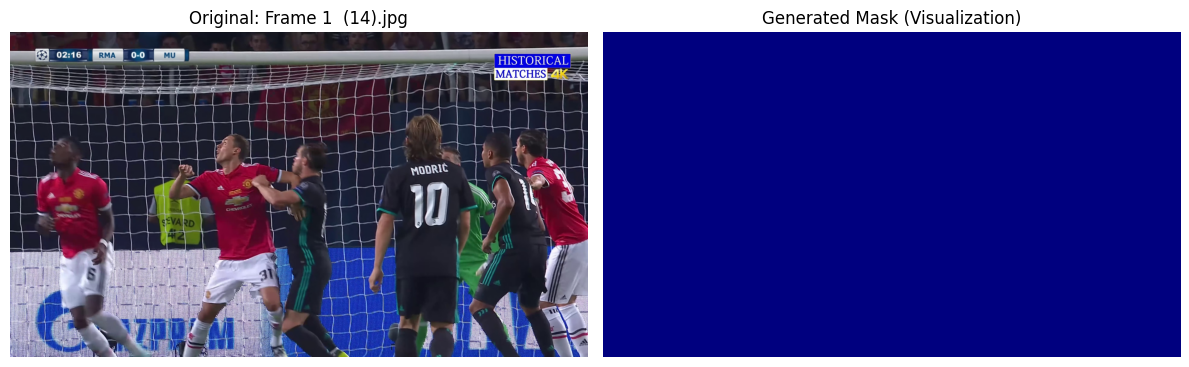

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw

# 1. 클래스 정보 확인 (ID -> 이름 매핑)
# categories 리스트를 {ID: 이름} 형태의 사전(Dict)으로 바꿉니다.
coco_classes = {cat['id']: cat['name'] for cat in coco_data['categories']}

print("클래스 목록 (ID : 이름):")
for cat_id, cat_name in coco_classes.items():
    print(f"   ID {cat_id} : {cat_name}")
print("-" * 30)

# 2. 랜덤한 이미지 하나 골라서 시각화 해보기
# JSON에 있는 이미지 정보 중 하나를 가져옵니다. (예: 첫 번째 이미지)
img_info = coco_data['images'][0]
img_id = img_info['id']
file_name = img_info['file_name']

print(f"시각화할 이미지: {file_name} (ID: {img_id})")

# 3. 해당 이미지에 해당하는 정답(Annotation)들만 골라내기
# 전체 915개 정답 중, 지금 고른 이미지(ID)에 해당하는 것만 찾습니다.
anns = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_id]
print(f"   찾은 객체(정답) 개수: {len(anns)}개")

# 4. 이미지 불러오기
try:
    # 이미지 파일명이 JSON과 실제 폴더에서 다를 수 있으니 확인해야 함
    # 보통 JSON에 'Frame 1.jpg'라고 되어 있으면 폴더에도 있어야 함
    img_path = os.path.join(image_dir, file_name)
    image = Image.open(img_path).convert("RGB")
    w, h = image.size
except Exception as e:
    print(f"이미지 로드 실패: {e}")
    # 만약 파일명이 달라서 실패하면, 폴더의 첫번째 파일을 강제로 씀 (테스트용)
    file_name = image_files[0]
    img_path = os.path.join(image_dir, file_name)
    image = Image.open(img_path).convert("RGB")
    print(f"대체 이미지 로드: {file_name}")

# 5. 마스크(정답 그림) 만들기
# 검은 도화지(0)를 만들고, 그 위에 정답 영역을 클래스 ID 색깔로 칠합니다.
mask = Image.new('L', (w, h), 0) # 'L' 모드는 흑백(0~255) 이미지
draw = ImageDraw.Draw(mask)

for ann in anns:
    category_id = ann['category_id']
    # segmentation 정보는 [[x1, y1, x2, y2, ...]] 형태의 다각형 점들입니다.
    for seg in ann['segmentation']:
        # 다각형 그리기 (안쪽을 category_id 값으로 채움)
        # category_id가 너무 작으면(1, 2..) 눈에 안 보일 수 있으니 * 20 해서 밝게 칠해봅니다. (시각화용)
        draw.polygon(seg, fill=category_id * 20, outline=category_id * 20)

# 6. 화면에 띄우기 (원본 vs 마스크)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title(f"Original: {file_name}")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Generated Mask (Visualization)")
plt.imshow(mask, cmap='jet') # 색깔 잘 보이게 'jet' 컬러맵 사용
plt.axis('off')

plt.tight_layout()
plt.show()

## **4. 데이터 전처리 & 데이터셋 구축**

### **4.1 클래스 ID 매핑(Class ID Mapping)**
1. 작업 의도 (Intent)
- 제공된 COCO 포맷의 JSON 데이터에서 각 클래스(객체)의 id는 1393250과 같이 매우 큰 정수로 되어 있습니다. 하지만 우리가 학습시킬 **Semantic Segmentation 모델(U-Net)**은 출력층에서 0부터 Class 개수 - 1까지의 연속된 정수(인덱스)를 정답(Label)으로 사용해야 손실 함수(CrossEntropyLoss)를 계산할 수 있습니다. 따라서, 원본의 큰 ID 값을 모델이 이해할 수 있는 0~10 사이의 연속된 인덱스로 변환하는 전처리 과정이 필요합니다.

2. 알고리즘 및 구현 방법
- 입력: coco_data['categories'] 리스트 (각 항목은 id와 name을 포함)

- 처리 과정: 파이썬의 Dictionary Comprehension 기능을 사용하여 두 가지 사전을 생성합니다.
    - id_to_label: 원본 ID(Key)를 입력하면 모델용 인덱스(Value)를 반환하는 사전. (데이터셋 구축 시 사용)
    - label_to_name: 모델용 인덱스(Key)를 입력하면 사람이 읽을 수 있는 클래스 이름(Value)을 반환하는 사전. (나중에 결과 시각화 시 사용)

- 결과: 총 11개의 클래스에 대해 0번부터 10번까지의 고유 번호가 부여됩니다.

In [7]:
# 1. 카테고리 정보 가져오기
categories = coco_data['categories']

# 2. 매핑 사전 만들기
# id_to_label: { 큰숫자ID : 0, 1, 2... } -> 모델 학습용
id_to_label = {cat['id']: i for i, cat in enumerate(categories)}

# label_to_name: { 0 : 'Goal Bar', 1 : 'Referee'... } -> 사람 확인용
label_to_name = {i: cat['name'] for i, cat in enumerate(categories)}

# 3. 결과 확인
print(f"총 클래스 개수: {len(id_to_label)}개")
print("\n[ID 변환표 예시] (Original ID -> Model Index):")
# 보기 좋게 앞부분 3개만 출력
for i, (orig_id, idx) in enumerate(id_to_label.items()):
    if i < 3:
        print(f"   Original ID [{orig_id}] -> Index [{idx}]")

print("\n[이름 확인표 예시] (Model Index -> Class Name):")
for i, (idx, name) in enumerate(label_to_name.items()):
    if i < 3:
        print(f"   Index [{idx}] -> Name [{name}]")

총 클래스 개수: 11개

[ID 변환표 예시] (Original ID -> Model Index):
   Original ID [1393250] -> Index [0]
   Original ID [1392807] -> Index [1]
   Original ID [1392806] -> Index [2]

[이름 확인표 예시] (Model Index -> Class Name):
   Index [0] -> Name [Goal Bar]
   Index [1] -> Name [Referee]
   Index [2] -> Name [Advertisements]


### **4.2 데이터셋 클래스 만들기**
1. 작업 의도 (Intent)
- 이미지 파일(JPG)과 좌표 정보(JSON)로 분리된 데이터를, 딥러닝 모델이 학습할 수 있는 **입력 텐서(Image Tensor)**와 정답 텐서(Mask Tensor) 쌍으로 변환하여 제공하는 파이프라인을 구축합니다. 특히 Segmentation 태스크를 위해, JSON의 다각형(Polygon) 좌표를 2D 이미지 형태의 Segmentation Mask로 실시간 변환하는 로직을 구현합니다.

2. 주요 알고리즘 및 함수 설명
- 클래스명: FootballDataset (torch.utils.data.Dataset 상속)
- __init__: 데이터 경로와 COCO 포맷의 JSON 데이터를 받아 초기화합니다. 이미지 ID별로 어떤 정답(Annotation)이 있는지 매핑하여 검색 속도를 최적화합니다.
- __getitem__ (핵심 로직):

  - 이미지 로드: 파일 경로에서 이미지를 읽어옵니다.
  - 마스크 생성 (Draw Mask): PIL.ImageDraw 모듈을 사용해 검은 배경(0)을 생성한 후, JSON에 기록된 좌표(Segmentation) 영역을 매핑된 클래스 ID(0~10) 값으로 채웁니다. (Polygon to Mask)
  - 전처리 (Preprocessing): 모델의 입력 크기에 맞춰 이미지와 마스크를 **동일한 크기(Resize)**로 변환합니다. 이때 마스크는 클래스 정보가 깨지지 않도록 보간법(Interpolation)에 주의합니다.
  - 반환 (Return): 이미지(0-1 실수형 텐서)와 마스크(0~10 정수형 텐서)를 튜플 형태로 반환합니다.

In [8]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image, ImageDraw
from collections import defaultdict

class FootballDataset(Dataset):
    def __init__(self, data_root, coco_data, id_to_label, target_size=(256, 256)):

        self.data_root = data_root  # 데이터가 있는 폴더 경로
        self.coco_data = coco_data  # JSON 파일 내용 (통째로 들고 있음)
        self.id_to_label = id_to_label  # 아까 만든 {큰숫자: 0~10} 변환표
        self.target_size = target_size  # 모델이 원하는 이미지 크기 (256, 256)

        # [핵심 로직] 데이터를 미리 '검색하기 좋게' 정리하기

        # 1. 사용할 이미지 ID 목록 (이게 있어야 몇 번째 데이터를 달라고 할지 앎)
        self.img_ids = [img['id'] for img in coco_data['images']]

        # 2. 이미지 정보 사전 (ID -> 파일명, 크기 정보)
        # 리스트를 매번 뒤지는 건 느리니까, ID만 대면 바로 정보를 뱉는 '사전(Dict)'으로 만듭니다.
        self.images_info = {img['id']: img for img in coco_data['images']}

        # 3. 정답(Annotation) 모으기
        self.coco_anns = defaultdict(list)
        for ann in coco_data['annotations']:
            self.coco_anns[ann['image_id']].append(ann)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        # 1. 이미지 파일 가져오기
        img_id = self.img_ids[idx]           # N번째 ID 꺼내기
        img_info = self.images_info[img_id]  # 아까 정리해둔 사전에서 정보 찾기
        file_name = img_info['file_name']    # 파일 이름 확인

        # 이미지 파일 열기
        img_path = os.path.join(self.data_root, 'images', file_name)
        try:
            image = Image.open(img_path).convert("RGB") # 컬러로 열기
        except:
            # 에러 방지용 (혹시 파일 없으면 첫 번째 파일로 대체)
            first_file = list(self.images_info.values())[0]['file_name']
            image = Image.open(os.path.join(self.data_root, 'images', first_file)).convert("RGB")

        w, h = image.size # 원본 크기 저장 (도화지 크기 맞춰야 하니까)


        # 2. 빈 도화지에 정답 색칠하기!!!!!!
        # 검은색(0) 배경 도화지 준비 ('L'모드 = 정수형)
        mask = Image.new('L', (w, h), 0)
        draw = ImageDraw.Draw(mask) # 화가 소환

        # 이 이미지에 해당하는 정답들(Annotations) 가져오기
        anns = self.coco_anns[img_id]

        for ann in anns:
            # 원래 ID (예: 1393250) -> 우리가 만든 ID (예: 0)
            original_id = ann['category_id']
            class_idx = self.id_to_label[original_id]

            # JSON에 있는 좌표들(segmentation)을 따라서 색칠하기
            for seg in ann['segmentation']:
                # seg는 [x1, y1, x2, y2...] 점들의 목록
                # fill=class_idx : 그 영역을 해당 클래스 번호(예: 1번)로 칠해라!
                draw.polygon(seg, fill=class_idx)


        # 3. 크기 조절 (Resize) & 텐서 변환

        # 이미지: 부드럽게 줄이기
        image = image.resize(self.target_size, Image.BILINEAR)

        # 마스크: 딱딱하게 줄이기 (값이 섞이면 안 됨!)
        mask = mask.resize(self.target_size, Image.NEAREST)

        # 4. 최종 변환 (Tensor)
        # 이미지는 0.0 ~ 1.0 실수(float)로 변환
        image_tensor = transforms.ToTensor()(image)

        # 마스크는 0, 1, 2 정수(int64/long)로 변환
        # (transforms.ToTensor를 쓰면 자동으로 0~1로 나눠버려서 쓰면 안 됨!)
        mask_array = np.array(mask) # 그림을 숫자 배열로
        mask_tensor = torch.from_numpy(mask_array).long() # 텐서로 포장

        return image_tensor, mask_tensor

### **4.3 데이터셋 검증 & 시각화**
1. 작업 의도
- 구축된 FootballDataset 클래스가 데이터를 올바르게 로드하고 전처리하는지 검증합니다.
    - 데이터 차원 확인: 모델 입력에 맞는 (Channel, Height, Width) 형태의 텐서가 반환되는지 확인합니다.
    - 시각적 정합성 확인: 원본 이미지와 생성된 마스크(Segmentation Map)를 시각화하여, 객체의 위치와 라벨이 일치하는지 육안으로 점검합니다.

2. 사용된 함수 설명
- permute(1, 2, 0): PyTorch 텐서는 (C, H, W) 순서이지만, 시각화 라이브러리(Matplotlib)는 (H, W, C) 순서를 요구합니다. 차원의 순서를 변경(Permutation)하여 이미지를 올바르게 출력합니다.
- cmap='jet': 마스크의 클래스 인덱스(0, 1, 2...)를 서로 다른 색상으로 표현하기 위해 컬러맵을 적용합니다.

데이터셋 전체 크기: 100장
이미지 텐서 모양 (C, H, W): torch.Size([3, 256, 256])
마스크 텐서 모양 (H, W):    torch.Size([256, 256])


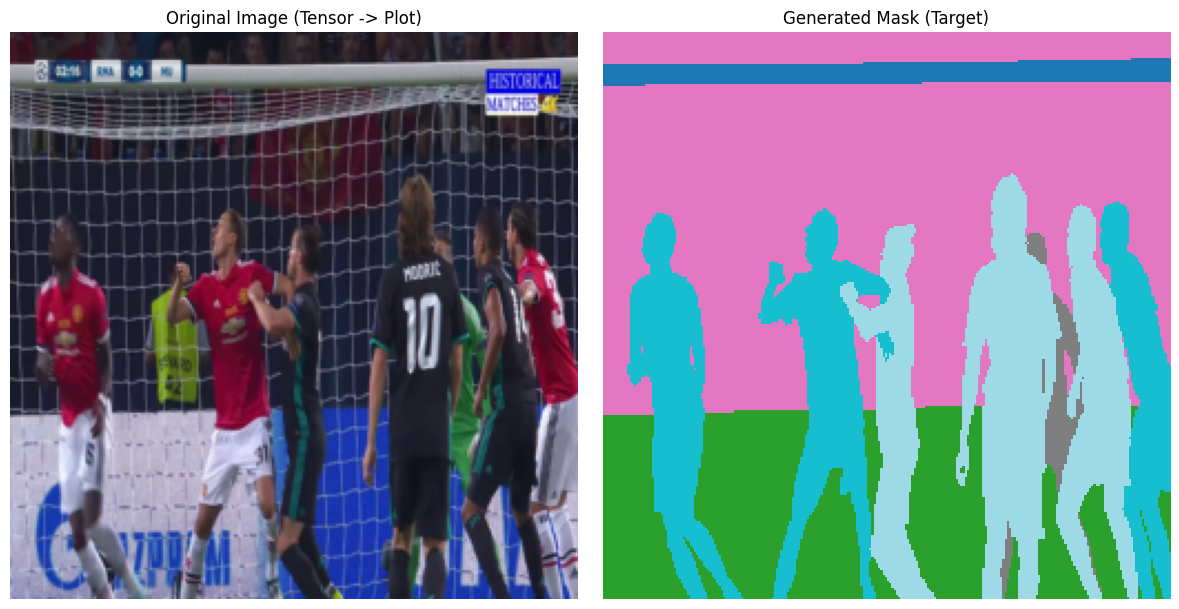

마스크에 포함된 고유 클래스 값: tensor([ 0,  2,  6,  7,  9, 10])


In [9]:
# 1. 데이터셋 인스턴스 생성
# transform은 아직 적용하지 않음 (기본 Resize만 적용됨)
train_dataset = FootballDataset(data_root='/content/data',
                                coco_data=coco_data,
                                id_to_label=id_to_label)

print(f"데이터셋 전체 크기: {len(train_dataset)}장")

# 2. 샘플 하나 가져오기
img_tensor, mask_tensor = train_dataset[0]

# 3. 차원(Shape) 확인 - 매우 중요!
print(f"이미지 텐서 모양 (C, H, W): {img_tensor.shape}")
print(f"마스크 텐서 모양 (H, W):    {mask_tensor.shape}")

# 4. 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.title("Original Image (Tensor -> Plot)")
# (3, 256, 256) -> (256, 256, 3)으로 바꿔야 그림이 그려짐
plt.imshow(img_tensor.permute(1, 2, 0))
plt.axis('off')

# 정답 마스크
plt.subplot(1, 2, 2)
plt.title("Generated Mask (Target)")
# 마스크는 (256, 256) 2차원이므로 바로 그릴 수 있음
# jet 컬러맵을 쓰면 0(배경)은 파랑, 값(객체)이 클수록 빨간색 쪽으로 보임
plt.imshow(mask_tensor, cmap='tab20', interpolation='nearest')
plt.axis('off')

plt.tight_layout()
plt.show()

# 5. 마스크에 어떤 클래스가 들어있는지 숫자로 확인
print("마스크에 포함된 고유 클래스 값:", torch.unique(mask_tensor))

### **4.4 데이터 분할 및 데이터로더 생성**
1. 작업 의도
- Hold-out Validation: 모델이 학습 데이터에만 과도하게 적합(Overfitting)되는 것을 방지하고, 본 적 없는 데이터에 대한 일반화 성능을 평가하기 위함
- Batch Processing: 전체 데이터를 한 번에 학습시키는 것은 메모리 한계로 불가능하므로, DataLoader를 통해 소량의 데이터(Batch) 묶음으로 나누어 모델에 공급합니다.

2. 구현 상세
- 분할 비율: 전체 100장의 이미지 중 약 80%는 학습용, 20%는 검증용으로 무작위 분할(random_split)합니다.
- Batch Size: GPU 메모리를 고려하여 한 번에 4장 또는 8장씩 학습하도록 설정합니다.
- Shuffle: 학습 데이터는 매 Epoch마다 순서를 섞어서(Shuffle=True) 모델이 데이터의 순서를 외우지 못하도록 합니다. (검증용은 섞을 필요 없음)

In [28]:
from torch.utils.data import DataLoader, random_split

# 1. 학습용/테스트용 개수 정하기
# 전체 데이터 개수 확인
total_size = len(train_dataset)
val_size = int(total_size * 0.2)
train_size = total_size - val_size

print(f"전체 데이터: {total_size}장")
print(f"학습용(Train): {train_size}장 / 검증용(Val): {val_size}장")

# 2. 무작위로 나누기 (Random Split)
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# 3. 데이터 로더
BATCH_SIZE = 4

train_loader = DataLoader(train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

val_loader = DataLoader(val_set,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

print("-" * 30)
print(f"데이터 로더 준비 완료!")
print(f"학습용 배치 개수: {len(train_loader)}개 (x {BATCH_SIZE}장 = {train_size}장)")
print(f"검증용 배치 개수: {len(val_loader)}개 (x {BATCH_SIZE}장 = {val_size}장)")

전체 데이터: 100장
학습용(Train): 80장 / 검증용(Val): 20장
------------------------------
데이터 로더 준비 완료!
학습용 배치 개수: 20개 (x 4장 = 80장)
검증용 배치 개수: 5개 (x 4장 = 20장)


## **5. 모델 설계 (U-Net Architecture)**

### **5.1 네트워크 구조 설계 전략 (Architecture Strategy)**
**1. 모델 선정 배경 (Objective)**

본 프로젝트의 목표는 축구 경기 영상 내에서 '축구공(매우 작은 객체)'부터 '잔디(넓은 배경)'까지 다양한 스케일의 객체를 픽셀 단위로 정밀하게 분할(Segmentation)하는 것입니다.이를 위해 의료 영상 분할 분야에서 제안되어 세밀한 경계 복원 능력이 입증된 U-Net (Ronneberger et al., 2015) 아키텍처를 채택했습니다.

**2. 핵심 아키텍처 전략 (Key Strategy)**

모델의 성능을 극대화하기 위해 다음과 같은 설계 전략을 수립했습니다.
- 대칭형 구조 (Symmetric Structure):
  - Encoder (Contracting Path): 이미지의 해상도를 점진적으로 줄이며 문맥(Context) 정보와 특징(Feature)을 압축 추출합니다.
  - Decoder (Expansive Path): 추출된 특징 맵을 다시 원본 해상도로 복원하여 픽셀별 위치 정보를 파악합니다.
- 스킵 연결 (Skip Connection):
  - 단순한 업샘플링(Up-sampling) 시 발생할 수 있는 위치 정보 소실 문제를 해결하기 위해 도입했습니다.
  - Encoder 단계의 고해상도 특징 맵(Feature Map)을 Decoder의 해당 레이어에 Concatenate(결합) 하여, 흐릿해질 수 있는 객체의 경계선을 선명하게 보정합니다.
  
**3. 구현 상세 (Implementation Details)**

코드의 유지보수성과 재사용성을 높이기 위해 모듈화된 설계를 적용합니다.
- DoubleConv 블록: (Conv2d - BatchNorm - ReLU) 연산이 두 번 반복되는 구조를 기본 단위로 정의하여 네트워크 깊이를 효율적으로 구성합니다.
- 입출력 차원:
  - Input: $(B, 3, 256, 256)$ - RGB 이미지
  - Output: $(B, 11, 256, 256)$ - 11개 클래스에 대한 픽셀별 확률값 (Logits)

### **5.2 U-Net 모델 구축**

In [11]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            # 1. 첫 번째 훑기 (눈)
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            # 2. 정돈하기 (반장)
            nn.BatchNorm2d(out_channels),
            # 3. 거르기 (거름망)
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        # [내려가는 길] 특징 추출 & 압축
        self.inc = DoubleConv(n_channels, 64) # 입력(3) -> 64개 특징 찾기

        # MaxPool2d(2): 크기를 반으로 줄임
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024)) # 바닥 도착

        # [올라가는 길] 복원 & 합치기
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512) # 합친 후 다듬기

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        # 마지막: 64개 특징을 11개 클래스(정답 개수)로 변환
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # 1. 인코더 (내려가면서 저장해두기)
        x1 = self.inc(x) # 나중에 쓰려고 x1에 저장!
        x2 = self.down1(x1) # x2에 저장!
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4) # 제일 작은 상태 (바닥)

        # 2. 디코더 (올라가면서 합치기)
        x = self.up1(x5) # 키우고
        # [중요] x4(왼쪽 정보)와 x(현재 정보)를 합침! (Skip Connection)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x) # 다듬기

        x = self.up2(x)
        x = torch.cat([x3, x], dim=1) # x3랑 합침
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x2, x], dim=1) # x2랑 합침
        x = self.conv3(x)

        x = self.up4(x)
        x = torch.cat([x1, x], dim=1) # x1이랑 합침
        x = self.conv4(x)

        # 3. 최종 출력
        logits = self.outc(x)
        return logits

## **6. 모델 학습 (Training)**

### **6.1 모델 생성 및 학습 환경 설정 (Configuration)**
1. 작업 의도 (Intent)
- Model Initialization: 정의된 UNet 클래스를 GPU 메모리에 로드하여 연산 가능한 상태로 만듭니다.
- Optimization Strategy: 픽셀 단위의 정교한 분류를 위해 안정적인 Adam 최적화 기법과 1e-4의 낮은 학습률을 채택합니다.
- Early Stopping (조기 종료): 불필요한 학습 시간을 단축하고 과적합(Overfitting)을 방지하기 위해, 검증 손실(Validation Loss)이 일정 기간 동안 개선되지 않으면 학습을 중단하는 전략을 도입합니다.


2. 알고리즘 및 파라미터 (Algorithm & - Hyperparameters)
Learning Rate (1e-4): 초기 학습률을 0.0001로 설정합니다. Segmentation 태스크는 손실 지형이 복잡하므로, 작은 보폭으로 신중하게 최적점을 탐색합니다.
- Loss Function: 다중 클래스(11개) 픽셀 분류 문제이므로 **CrossEntropyLoss**를 사용합니다.
- Early Stopping Logic:
  - PATIENCE (참을성): 검증 점수가 나아지지 않아도 몇 번까지 참을 것인가? (설정값: 5~10회)
  - 만약 PATIENCE 횟수만큼 기다려도 최고 점수(Best Loss)가 갱신되지 않으면 학습을 강제로 종료합니다.


3. 주요 함수 설명 (Function Description)
- optim.Adam(params, lr): Momentum과 RMSProp의 장점을 결합한 최적화 알고리즘으로, 대부분의 딥러닝 태스크에서 수렴 속도가 빠르고 안정적입니다.
- nn.CrossEntropyLoss(): Softmax 활성화 함수와 NLLLoss(Negative Log Likelihood Loss)가 결합된 형태로, 모델의 출력값(Logits)과 정답(Mask) 간의 차이를 계산합니다.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. 모델 실체화 (Model Instantiation)
# 입력 채널: 3 (RGB), 클래스 개수: 11
model = UNet(n_channels=3, n_classes=11).to(device)

# 2. 학습 파라미터 및 도구 설정 (Configuration)
# 손실 함수: 픽셀별 다중 분류
criterion = nn.CrossEntropyLoss()

# 최적화 기법: Adam (학습률 1e-4 = 0.0001)
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 학습 횟수 (넉넉하게 30번 주되, 조기 종료로 제어)
NUM_EPOCHS = 30

# 3. Early Stopping 설정
PATIENCE = 5
counter = 0
best_val_loss = float('inf') # 역대 최고 점수 (초기값은 무한대)

# 학습 기록 저장소
history = {'train_loss': [], 'val_loss': []}

print("-" * 30)
print("학습 준비 완료 (Training Setup Completed)")
print(f"   Device: {device}")
print(f"   Model: U-Net (Input: 3, Classes: 11)")
print(f"   Optimizer: Adam (LR: {LEARNING_RATE})")
print(f"   Early Stopping Patience: {PATIENCE}")
print("-" * 30)

------------------------------
학습 준비 완료 (Training Setup Completed)
   Device: cuda
   Model: U-Net (Input: 3, Classes: 11)
   Optimizer: Adam (LR: 0.0001)
   Early Stopping Patience: 5
------------------------------


### **6.2 모델 학습 및 검증 (Training & Validation Loop)**
**1. 작업 의도 (Intent)**
- Iterative Learning: 설정된 Epoch 수만큼 반복하며 모델을 학습(Train)시키고, 매 Epoch마다 검증(Validation)을 수행합니다.
- Performance Monitoring: 학습 손실(Train Loss)과 검증 손실(Val Loss)을 실시간으로 기록하여 과적합(Overfitting) 여부를 판단합니다.
- Best Model Saving: 검증 성능이 가장 좋은 순간의 모델 가중치를 best_model.pth 파일로 자동 저장합니다.

**2. 핵심 로직 및 함수 설명 (Core Logic & Functions)**
- model.train() vs model.eval():
  - 학습 시에는 train() 모드로 설정하여 가중치를 업데이트합니다.
  - 검증 시에는 eval() 모드로 설정하고, torch.no_grad()를 사용하여 메모리 사용을 줄이고 평가 속도를 높입니다.

- Early Stopping (조기 종료):
  - PATIENCE 횟수만큼 검증 손실이 개선되지 않으면, 학습이 더 이상 유의미하지 않다고 판단하고 강제로 중단하여 시간을 절약합니다.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import copy

# 1. Criterion 정의
criterion = nn.CrossEntropyLoss()

# 2. 학습 함수 (train) 정의
# 엔진 C (Segmentation 버전에 맞춰 Pixel Accuracy 계산으로 수정됨)
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # 학습 모드로 설정(Dropout On)
    running_loss, correct, total = 0.0, 0, 0

    # 회원님 스타일대로 tqdm을 for문에 직접 사용
    for images, masks in tqdm(train_loader, desc="Train Loop"):

        # (1) 데이터와 라벨을 GPU(device)로 이동
        images, masks = images.to(device), masks.to(device)

        # (2) 옵티마이저 기울기 초기화
        optimizer.zero_grad()

        # (3) 순전파 (Forward)
        outputs = model(images)  # (Batch, 11, 256, 256)

        # (4) 손실 계산
        loss = criterion(outputs, masks)

        # (5) 역전파 (Backward)
        loss.backward()

        # (6) 옵티마이저 업데이트
        optimizer.step()

        # 성능 기록용
        running_loss += loss.item() * images.size(0)

        # 정확도 계산 (Pixel Accuracy)
        # argmax(dim=1): 확률이 가장 높은 클래스 인덱스 선택
        preds = outputs.argmax(dim=1)

        # [수정] 세그멘테이션은 픽셀 단위로 비교해야 함
        total += masks.numel() # 전체 픽셀 개수 (Batch * H * W)
        correct += (preds == masks).sum().item() # 맞춘 픽셀 개수

    epoch_loss = running_loss / len(train_loader.dataset) # 배치 크기 보정된 평균 손실
    epoch_acc = 100 * correct / total  # 픽셀 정확도 (%)

    return epoch_loss, epoch_acc


# 3. 평가 함수 (evaluate) 정의
# 엔진 C
def evaluate(model, val_loader, criterion, device):

    model.eval()  # 모델을 '평가 모드'로 설정 (Dropout Off)
    running_loss, correct, total = 0.0, 0, 0

    # 기울기 계산 안 함 => 메모리 절약, 계산 속도 향상
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Eval Loop"):

            # (1) 데이터와 라벨을 GPU(device)로 이동
            images, masks = images.to(device), masks.to(device)

            # (2) 순전파 (Forward)
            outputs = model(images)

            # (3) 손실 계산
            loss = criterion(outputs, masks)

            # 성능 기록용
            running_loss += loss.item() * images.size(0)

            # 정확도 계산 (Pixel Accuracy)
            preds = outputs.argmax(dim=1)
            total += masks.numel()
            correct += (preds == masks).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


# 4. 시각화 함수 (plot_history) 정의
def plot_history(train_loss, val_loss, train_acc, val_acc, model_name="U-Net"):
    # 훈련 과정의 손실(Loss)과 정확도(Accuracy) 변화를 시각화하는 함수
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # (1) 손실(Loss) 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss') # 점선 대신 실선 사용
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'Loss vs. Epochs ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # (2) 정확도(Accuracy) 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'Pixel Accuracy vs. Epochs ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("공통 학습/검증 도구 세팅 완료 (함수 정의됨)")

공통 학습/검증 도구 세팅 완료 (함수 정의됨)


### **6.3 훈련 실행(Training Loop)**

In [14]:
# 학습 파라미터 재설정
NUM_EPOCHS = 30
PATIENCE = 5
SAVE_PATH = 'best_model.pth'

# 기록용 리스트
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 최적 모델 저장 변수 초기화
best_val_loss = float('inf')
counter = 0

print(f"U-Net 모델 훈련 시작 (Total {NUM_EPOCHS} Epochs)")
print(f"   저장 경로: {SAVE_PATH}")
print("-" * 60)

start_time = time.time() # 전체 시간 측정

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()

    # 1. 훈련 (함수 호출 한 줄로 끝!)
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)

    # 2. 검증 (함수 호출 한 줄로 끝!)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # 3. 기록 저장
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    # 4. 최적 모델 저장 (Early Stopping 체크)
    save_msg = ""
    # Loss가 줄어들어야 좋은 것이므로 < 부등호 사용
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), SAVE_PATH)
        save_msg = f"    (🎉 최적 성능 갱신: Loss {best_val_loss:.4f} -> 저장 완료!)"
    else:
        counter += 1
        save_msg = f"    (No Improve: {counter}/{PATIENCE})"

    # 5. 결과 출력 (깔끔한 포맷)
    epoch_time = time.time() - epoch_start
    print(f"\n[Epoch {epoch:02d} / {NUM_EPOCHS}] | Time: {epoch_time:.0f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc  : {val_acc:.2f}%")
    print(save_msg)
    print("-" * 30)

    # 조기 종료 발동
    if counter >= PATIENCE:
        print(f"조기 종료 (Early Stopping)! Best Loss: {best_val_loss:.4f}")
        break

total_time = time.time() - start_time
print(f"🏁 훈련 종료! 총 소요 시간: {total_time//60:.0f}분 {total_time%60:.0f}초")

# 최적 가중치 로드
model.load_state_dict(torch.load(SAVE_PATH))
print(f"모델에 최적 성능 가중치를 로드했습니다.")

U-Net 모델 훈련 시작 (Total 30 Epochs)
   저장 경로: best_model.pth
------------------------------------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 01 / 30] | Time: 12s
  Train Loss: 1.9666 | Train Acc: 50.73%
  Val Loss  : 2.1716 | Val Acc  : 55.99%
    (🎉 최적 성능 갱신: Loss 2.1716 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 02 / 30] | Time: 10s
  Train Loss: 1.4424 | Train Acc: 78.37%
  Val Loss  : 1.3940 | Val Acc  : 78.47%
    (🎉 최적 성능 갱신: Loss 1.3940 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 03 / 30] | Time: 11s
  Train Loss: 1.2672 | Train Acc: 82.80%
  Val Loss  : 1.1017 | Val Acc  : 82.86%
    (🎉 최적 성능 갱신: Loss 1.1017 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 04 / 30] | Time: 10s
  Train Loss: 1.1440 | Train Acc: 84.85%
  Val Loss  : 0.9926 | Val Acc  : 87.96%
    (🎉 최적 성능 갱신: Loss 0.9926 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 05 / 30] | Time: 10s
  Train Loss: 1.0573 | Train Acc: 86.79%
  Val Loss  : 0.9591 | Val Acc  : 88.01%
    (🎉 최적 성능 갱신: Loss 0.9591 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 06 / 30] | Time: 10s
  Train Loss: 0.9862 | Train Acc: 88.04%
  Val Loss  : 0.8389 | Val Acc  : 90.88%
    (🎉 최적 성능 갱신: Loss 0.8389 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 07 / 30] | Time: 11s
  Train Loss: 0.8954 | Train Acc: 90.15%
  Val Loss  : 0.7908 | Val Acc  : 91.59%
    (🎉 최적 성능 갱신: Loss 0.7908 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 08 / 30] | Time: 11s
  Train Loss: 0.8543 | Train Acc: 90.58%
  Val Loss  : 0.7535 | Val Acc  : 92.57%
    (🎉 최적 성능 갱신: Loss 0.7535 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 09 / 30] | Time: 11s
  Train Loss: 0.8315 | Train Acc: 90.61%
  Val Loss  : 0.6862 | Val Acc  : 91.23%
    (🎉 최적 성능 갱신: Loss 0.6862 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 10 / 30] | Time: 10s
  Train Loss: 0.7685 | Train Acc: 91.47%
  Val Loss  : 0.7250 | Val Acc  : 92.78%
    (No Improve: 1/5)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 11 / 30] | Time: 11s
  Train Loss: 0.7104 | Train Acc: 92.07%
  Val Loss  : 0.6175 | Val Acc  : 93.97%
    (🎉 최적 성능 갱신: Loss 0.6175 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 12 / 30] | Time: 11s
  Train Loss: 0.6747 | Train Acc: 93.04%
  Val Loss  : 0.6133 | Val Acc  : 92.79%
    (🎉 최적 성능 갱신: Loss 0.6133 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 13 / 30] | Time: 10s
  Train Loss: 0.6680 | Train Acc: 92.99%
  Val Loss  : 0.9847 | Val Acc  : 80.33%
    (No Improve: 1/5)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 14 / 30] | Time: 10s
  Train Loss: 0.6918 | Train Acc: 91.38%
  Val Loss  : 0.5692 | Val Acc  : 91.75%
    (🎉 최적 성능 갱신: Loss 0.5692 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 15 / 30] | Time: 10s
  Train Loss: 0.6099 | Train Acc: 92.58%
  Val Loss  : 0.4913 | Val Acc  : 93.95%
    (🎉 최적 성능 갱신: Loss 0.4913 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 16 / 30] | Time: 10s
  Train Loss: 0.5849 | Train Acc: 93.50%
  Val Loss  : 0.5203 | Val Acc  : 94.30%
    (No Improve: 1/5)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 17 / 30] | Time: 11s
  Train Loss: 0.5059 | Train Acc: 94.47%
  Val Loss  : 0.4538 | Val Acc  : 94.85%
    (🎉 최적 성능 갱신: Loss 0.4538 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 18 / 30] | Time: 11s
  Train Loss: 0.4735 | Train Acc: 94.67%
  Val Loss  : 0.4212 | Val Acc  : 95.28%
    (🎉 최적 성능 갱신: Loss 0.4212 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 19 / 30] | Time: 11s
  Train Loss: 0.4616 | Train Acc: 94.92%
  Val Loss  : 0.4002 | Val Acc  : 95.54%
    (🎉 최적 성능 갱신: Loss 0.4002 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 20 / 30] | Time: 11s
  Train Loss: 0.4211 | Train Acc: 95.39%
  Val Loss  : 0.3940 | Val Acc  : 95.82%
    (🎉 최적 성능 갱신: Loss 0.3940 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 21 / 30] | Time: 10s
  Train Loss: 0.4029 | Train Acc: 95.49%
  Val Loss  : 0.3477 | Val Acc  : 95.64%
    (🎉 최적 성능 갱신: Loss 0.3477 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 22 / 30] | Time: 10s
  Train Loss: 0.4317 | Train Acc: 95.13%
  Val Loss  : 0.3628 | Val Acc  : 95.21%
    (No Improve: 1/5)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 23 / 30] | Time: 11s
  Train Loss: 0.4063 | Train Acc: 95.32%
  Val Loss  : 0.3355 | Val Acc  : 95.75%
    (🎉 최적 성능 갱신: Loss 0.3355 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 24 / 30] | Time: 11s
  Train Loss: 0.3871 | Train Acc: 95.25%
  Val Loss  : 0.3288 | Val Acc  : 95.35%
    (🎉 최적 성능 갱신: Loss 0.3288 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 25 / 30] | Time: 11s
  Train Loss: 0.3932 | Train Acc: 95.40%
  Val Loss  : 0.3207 | Val Acc  : 96.11%
    (🎉 최적 성능 갱신: Loss 0.3207 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 26 / 30] | Time: 11s
  Train Loss: 0.3519 | Train Acc: 96.03%
  Val Loss  : 0.2968 | Val Acc  : 96.00%
    (🎉 최적 성능 갱신: Loss 0.2968 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 27 / 30] | Time: 11s
  Train Loss: 0.3301 | Train Acc: 96.33%
  Val Loss  : 0.2930 | Val Acc  : 96.42%
    (🎉 최적 성능 갱신: Loss 0.2930 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 28 / 30] | Time: 10s
  Train Loss: 0.2941 | Train Acc: 96.29%
  Val Loss  : 0.2839 | Val Acc  : 96.01%
    (🎉 최적 성능 갱신: Loss 0.2839 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 29 / 30] | Time: 10s
  Train Loss: 0.3108 | Train Acc: 96.19%
  Val Loss  : 0.2810 | Val Acc  : 96.04%
    (🎉 최적 성능 갱신: Loss 0.2810 -> 저장 완료!)
------------------------------


Train Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Eval Loop:   0%|          | 0/5 [00:00<?, ?it/s]


[Epoch 30 / 30] | Time: 11s
  Train Loss: 0.3021 | Train Acc: 96.62%
  Val Loss  : 0.2669 | Val Acc  : 96.52%
    (🎉 최적 성능 갱신: Loss 0.2669 -> 저장 완료!)
------------------------------
🏁 훈련 종료! 총 소요 시간: 5분 16초
모델에 최적 성능 가중치를 로드했습니다.


**1. 학습 요약**
|구분|결과|비고|
|:---|:---|:---|
|**총 진행 Epoch**|30 / 30|설정된 횟수 완주 (조기 종료 미발동)|
|**최고 성능 시점**|Epoch 30|마지막 에폭에서 최고 성능 달성|
|**최고 검증 손실**|0.2669 (Best Loss)|학습 부족|
|**최고 검증 정확도**|96.52% (Pixel Acc)|수치는 높으나 클래스 불균형 고려 필요|

**2. 상세 분석 (Detailed Insights)**
- 초기 상태 불안정: 학습 초기 Loss가 1.97로 매우 높게 시작했습니다. (이전 실험은 0.3대 시작) 이는 데이터 분할(Split) 시 학습하기 어려운 데이터들이 검증셋에 포함되었거나, 가중치 초기화가 불리하게 되었을 가능성을 시사합니다.

- 지속적인 학습 (Underfitting): 종료 시점인 Epoch 30까지도 Loss가 계속 줄어들고 있습니다(0.28 -> 0.26). 이는 모델이 아직 수렴하지 못했으며, **더 많은 학습(Epoch 증가)**이 필요함을 의미합니다.

- 신뢰성 이슈: 적은 데이터셋(100장)으로 인해 학습 때마다 성능 편차가 큽니다. 이를 해결하기 위해 시드(Seed) 고정이나 K-Fold 교차 검증 도입이 시급합니다.

## **7. 학습 결과 시각화 (Training Visualization)**

### **7.1 시각화 전략 및 분석 도구 (Strategy & Tools)**
1. 작업 의도 (Intent)
- Trend Analysis (추세 분석): 텍스트 로그만으로는 파악하기 힘든 학습의 전반적인 흐름을 **선 그래프(Line Plot)**로 시각화합니다.
- Diagnosis (진단):
  - Loss Curve: 모델이 안정적으로 수렴하는지, 과적합(Overfitting)이 발생하여 Train/Val 격차가 벌어지지 않는지 확인합니다.
  - Accuracy Curve: 픽셀 정확도(Pixel Accuracy)가 목표 수준까지 도달했는지 확인합니다.

2. 분석 포인트 (Key Points)
- Gap Check: Training 곡선과 Validation 곡선이 서로 붙어서 내려가는 것이 이상적입니다.
- Best Checkpoint: Best Model이 저장된 지점(Epoch) 이후로 Loss가 다시 튀어 오르지는 않았는지 확인합니다.

### **7.2 결과 시각화 및 분석**

학습 결과 그래프 시각화


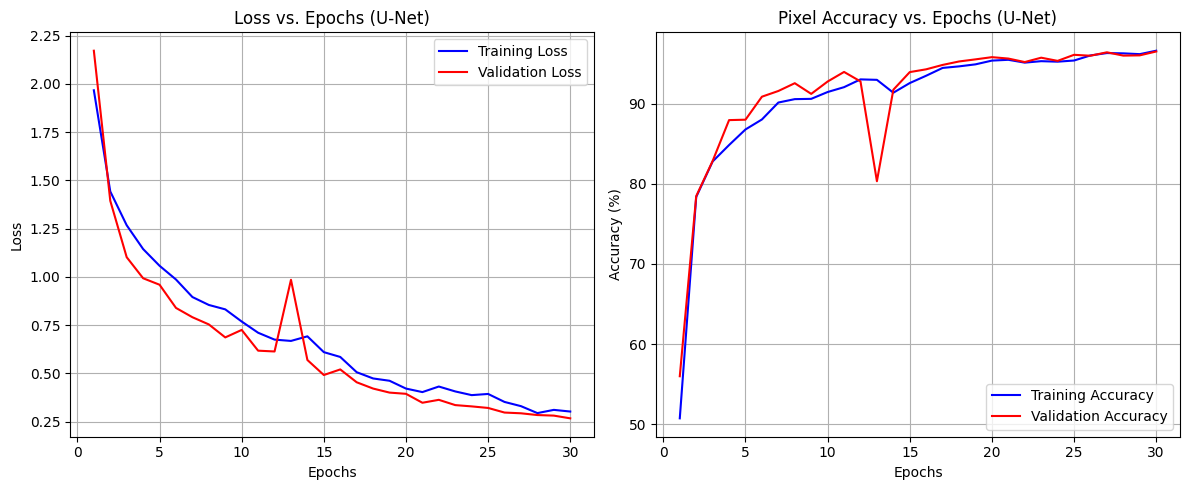

In [17]:
# 학습 루프에서 모은 기록(history)이 있는지 확인
if 'history' in locals() and len(history['train_loss']) > 0:
    print("학습 결과 그래프 시각화")

    # 아까 정의해둔 함수 호출 (Train Loss, Val Loss, Train Acc, Val Acc 순서)
    plot_history(
        history['train_loss'],
        history['val_loss'],
        history['train_acc'],
        history['val_acc'],
        model_name="U-Net"
    )
else:
    print("학습 기록(history)이 없습니다. 6.3 학습 코드를 먼저 실행해주세요.")

**그래프 분석 (Graph Analysis)**

**1. Loss (왼쪽 그래프):**
- 파란선(Train Loss): 초반에 급격히 떨어지다가 완만하게 계속 내려가고 있습니다. (학습은 잘 되고 있음)
- 빨간선(Validation Loss): 초반엔 잘 따라 내려가다가, **Epoch 12 이후로 오르락내리락(불안정)**하거나 살짝 올라가는 경향이 보입니다.
- 결론: 모델이 학습 데이터에는 점점 더 잘 맞아가고 있지만, 검증 데이터에 대해서는 **어느 시점 이후로는 더 이상 좋아지지 않고 있다(Overfitting 조짐)**는 것을 보여줍니다.

**2. Accuracy (오른쪽 그래프):**
- 둘 다 96~98% 사이의 높은 구간에 있습니다.
- 하지만, 이건 "잔디밭 효과(Class Imbalance)" 때문일 가능성이 큽니다. 숫자가 높다고 안심할 수 없음.

## **8. 성능 평가 및 시각화**

### **8.1 예측 결과 시각화 (Qualitative Evaluation)**

1. 작업 의도 (Intent)
- Visual Inspection: 정량적 지표(Loss, Acc)만으로는 파악하기 힘든 모델의 실제 성능을 육안으로 검증합니다.
- Segmentation Quality: 객체의 경계선(Boundary)을 얼마나 정교하게 따냈는지, 작은 객체(공, 선수)를 놓치지 않았는지 확인합니다.

2. 시각화 방법 (Method)
- 검증 데이터셋(val_loader)에서 무작위로 샘플 이미지를 추출합니다.
- Original Image (원본) - Ground Truth (정답지) - Prediction (AI 예측) 세 가지를 나란히 출력하여 비교합니다.

### **8.2 테스트 이미지 예측 및 시각화 함수**

모델 예측 결과 시각화 (Inference Check)


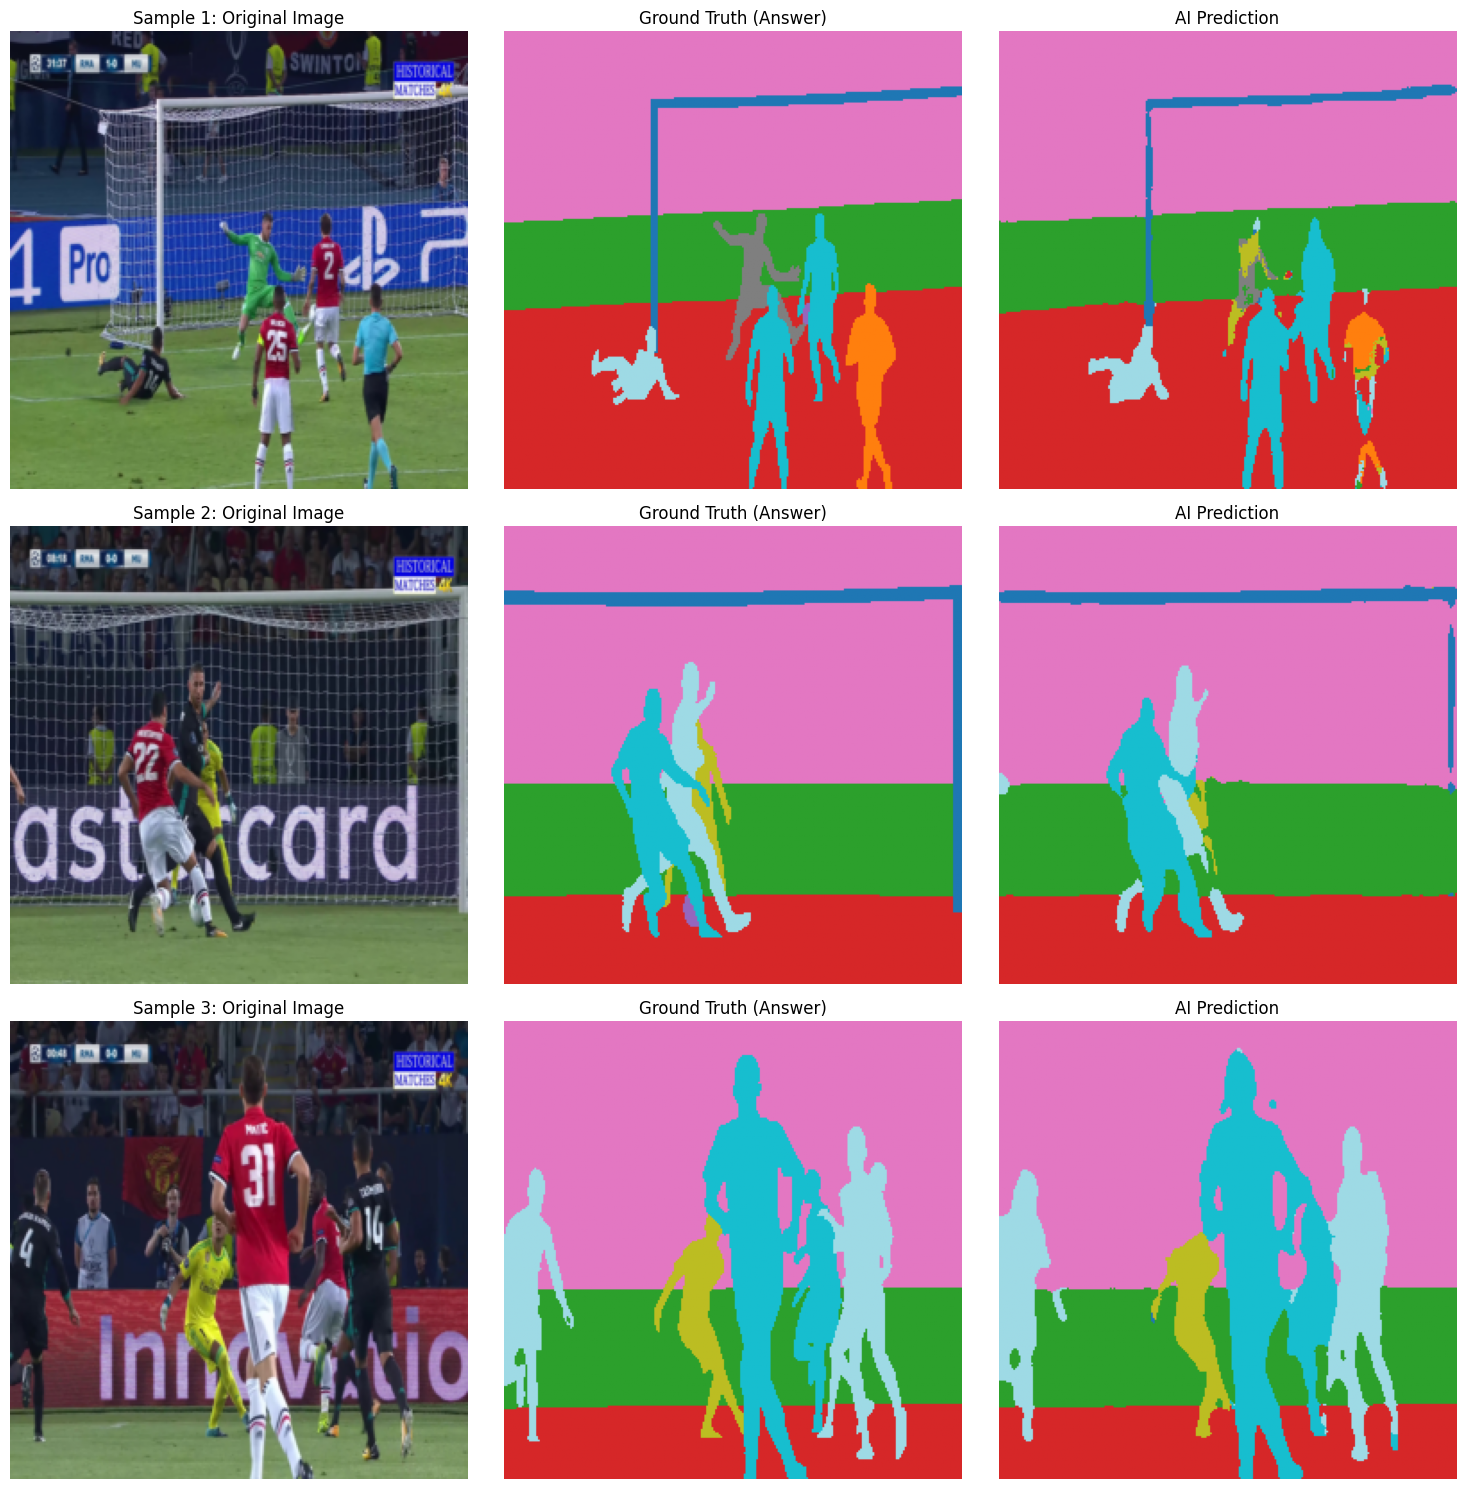

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_predictions(model, loader, device, num_samples=3):

    model.eval()

    # 데이터 한 배치 가져오기
    # iter()로 로더를 반복자로 만들고 next()로 첫 번째 배치를 꺼냅니다.
    images, masks = next(iter(loader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1) # 가장 높은 확률인 클래스 선택

    # 시각화를 위해 CPU로 이동 및 Numpy 변환
    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    # 클래스별 색상을 구분하기 위한 컬러맵 설정 (tab20 추천)
    cmap = plt.get_cmap('tab20')

    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # 1. 원본 이미지 (Tensor [C,H,W] -> Numpy [H,W,C])
        img = images[i].permute(1, 2, 0).numpy()

        # 2. 정답 마스크
        gt_mask = masks[i].numpy()

        # 3. 예측 마스크
        pred_mask = preds[i].numpy()

        # --- 그림 그리기 ---
        # (1) 원본 이미지
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img)
        plt.title(f"Sample {i+1}: Original Image")
        plt.axis('off')

        # (2) 실제 정답 (Ground Truth)
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(gt_mask, cmap=cmap, vmin=0, vmax=10)
        plt.title("Ground Truth (Answer)")
        plt.axis('off')

        # (3) 예측 결과 (AI Prediction)
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred_mask, cmap=cmap, vmin=0, vmax=10)
        plt.title("AI Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 시각화 실행 (검증 데이터셋에서 3개 샘플 확인)
if 'model' in locals() and 'val_loader' in locals():
    print("모델 예측 결과 시각화 (Inference Check)")
    visualize_predictions(model, val_loader, device, num_samples=3)
else:
    print("모델이나 데이터 로더가 준비되지 않았습니다.")

### **8.3 시각화 결과 분석**
**성능 고도화 전략 (Performance Optimization)**

**1. 현재 상황 진단 (Diagnosis)현상:**
- 학습이 진행될수록 Train Loss는 감소하나 Validation Loss는 정체되거나 불안정함.
- 원인:
  - 데이터 부족: 100장의 이미지만으로는 모델이 일반화된 패턴을 배우기 어려움.
  - 학습 부족: 30 Epoch으로는 모델이 충분히 수렴하지 못함.
- 결론: 현재 모델은 과소적합(Underfitting) 상태이며, 데이터 다양성 확보와 학습 시간 연장이 필요함.

**2. 핵심 업그레이드 전략 (Action Plan)**
**전략 1: 데이터 증강 (Data Augmentation)**
- 목표: 원본 이미지에 변화를 주어 데이터셋의 크기를 논리적으로 확장(뻥튀기)함.
- 적용 기법:
  - Horizontal Flip: 이미지를 좌우로 뒤집어 '다른 경기장'처럼 보이게 함.
  - Rotation: 약간의 회전(±10도)을 주어 카메라 앵글 변화에 대응.
  - Color Jitter: 밝기, 대비를 조절하여 다양한 조명 환경을 모사.
  - 주의: 이미지 변형 시 마스크(정답지)도 반드시 동일하게 변형되어야 함.
  
- **전략 2: 학습량 증대 (Extended Training)**
- 목표: 모델이 최적점(Global Minimum)에 도달할 때까지 충분한 시간을 부여.
- 설정 변경:
  - Epoch: 30 $\rightarrow$ 100 (충분한 학습 기회 제공)
  - Patience: 5 $\rightarrow$ 15 (일시적인 정체 구간을 견딜 수 있도록 인내심 증가)

## **9. 모델 성능 개선 (Model Improvement)**

### **9.1 성능 개선 전략 (Optimization Strategy)**

**1. 문제 정의:**
- 현재 모델은 100장의 적은 데이터로 학습하여, 데이터의 다양성이 부족합니다.
- 기존 FootballDataset은 단순히 크기 조절(Resize)만 수행하므로, 모델이 이미지를 외워버리는 과적합(Overfitting) 위험이 큽니다.

**2. 해결 방안 (Data Augmentation):**
- 기존의 실시간 마스크 생성 로직을 유지하되, 이미지가 생성된 직후에 변형(Augmentation)을 가하는 방식을 적용합니다.
- Albumentations 라이브러리를 사용하여 이미지와 마스크를 **동시에 변형(동기화)**시킵니다.
- 주의점: ImageDraw로 그린 마스크는 PIL 형태이므로, 이를 Numpy 배열로 변환하여 증강을 적용한 뒤, 다시 Tensor로 변환해야 합니다.

### **9.2 데이터셋 클래스 업그레이드 (Dataset Refactoring)**
기존 4.2의 FootballDataset을 상속받거나 새로 정의하여, transforms (증강 파이프라인) 기능을 추가합니다.

**핵심 변경 사항:**
1. __init__에서 transforms 인자를 받도록 수정.
2. __getitem__에서 ImageDraw로 마스크를 그린 직후, transforms가 있다면 적용하도록 로직 추가.

In [29]:
import numpy as np
import torch
import cv2
from torch.utils.data import Dataset
from PIL import Image, ImageDraw
import albumentations as A
from albumentations.pytorch import ToTensorV2

class FootballDatasetAug(Dataset):
    def __init__(self, data_root, coco_data, id_to_label, transforms=None):
        self.data_root = data_root
        self.coco_data = coco_data
        self.id_to_label = id_to_label
        self.transforms = transforms  # Albumentations 변환기

        # 데이터 인덱싱 (기존 로직 동일)
        self.img_ids = [img['id'] for img in coco_data['images']]
        self.images_info = {img['id']: img for img in coco_data['images']}
        self.coco_anns = {img['id']: [] for img in coco_data['images']}
        for ann in coco_data['annotations']:
            self.coco_anns[ann['image_id']].append(ann)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        # 1. 이미지 로드 (기존 로직)
        img_id = self.img_ids[idx]
        img_info = self.images_info[img_id]
        img_path = os.path.join(self.data_root, 'images', img_info['file_name'])

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            # 예외 처리: 파일이 없을 경우 첫 번째 이미지 사용
            first_file = list(self.images_info.values())[0]['file_name']
            image = Image.open(os.path.join(self.data_root, 'images', first_file)).convert("RGB")

        w, h = image.size

        # 2. 마스크 즉석 생성 (기존 로직: ImageDraw 사용)
        mask = Image.new('L', (w, h), 0)
        draw = ImageDraw.Draw(mask)

        anns = self.coco_anns[img_id]
        for ann in anns:
            cat_idx = self.id_to_label[ann['category_id']]
            for seg in ann['segmentation']:
                draw.polygon(seg, fill=cat_idx)

        # 3. [변경] Albumentations 적용을 위한 형변환 (PIL -> Numpy)
        image_np = np.array(image)
        mask_np = np.array(mask)

        # 4. [핵심] 데이터 증강 적용
        if self.transforms:
            # 이미지와 마스크를 동시에 변형 (동기화)
            augmented = self.transforms(image=image_np, mask=mask_np)
            image_np = augmented['image']
            mask_np = augmented['mask']

        # 5. 결과 반환 (이미 Tensor로 변환되었음)
        # 마스크가 float이 아닌 long(정수) 타입이어야 함에 주의
        if isinstance(mask_np, torch.Tensor):
            mask_tensor = mask_np.long()
        else:
            mask_tensor = torch.from_numpy(mask_np).long()

        return image_np, mask_tensor

In [23]:
!pip install albumentations -q

In [24]:
# 1단계: 변환 규칙 정의
# 학습용(Train)과 검증용(Val)을 따로 만드는 것이 핵심입니다.
# A.Compose: 여러 변환 단계를 묶어주는 파이프라인(Pipeline) 역할을 합니다.
# p=0.5: 50%의 확률로 이 변환을 적용하라는 뜻입니다. (매번 다르면 학습 효과가 좋기 때문)

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np

# 1. 학습용 변환 (Train Transform): 다양하게 비틀고 꼬아서 강하게 키웁니다.
def get_train_transform():
    return A.Compose([
        A.Resize(256, 256),                 # 모든 이미지를 256x256으로 고정
        A.HorizontalFlip(p=0.5),            # 50% 확률로 좌우 반전 (축구장은 대칭이라 유효함)
        A.ShiftScaleRotate(                 # 이동, 크기조절, 회전을 동시에 약간씩 적용
            shift_limit=0.05,               # 이동 범위
            scale_limit=0.05,               # 크기 조절 범위
            rotate_limit=15,                # 회전 각도 (너무 많이 돌리면 이상해짐)
            p=0.5
        ),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5), # 색상 미세 조정
        A.RandomBrightnessContrast(p=0.5),  # 밝기와 대비 조절 (날씨/조명 대응)
        A.Normalize(                        # 정규화 (이미지 픽셀을 0~1 사이로 맞춤)
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2()                        # PyTorch 텐서로 변환
    ])

# 2. 검증용 변환 (Val Transform): 정답을 맞춰야 하니 왜곡하지 않고 규격만 맞춥니다.
def get_val_transform():
    return A.Compose([
        A.Resize(256, 256),                 # 크기 통일
        A.Normalize(                        # 정규화 (학습 때와 동일한 기준 적용)
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2()                        # 텐서 변환
    ])

In [25]:
# 2단계: Dataset 클래스 업그레이드
# 기존 FootballDataset에 transform 파라미터를 추가하여,
# 이미지를 불러올 때 위에서 만든 규칙을 적용하도록 수정합니다.

from torch.utils.data import Dataset
from PIL import Image
import os
import torch

class FootballDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        # 이미지와 마스크 파일 경로 리스트 생성 (기존 로직 유지)
        self.image_dir = os.path.join(data_dir, 'images')
        self.mask_dir = os.path.join(data_dir, 'masks')

        # 파일 이름 정렬해서 리스트로 저장
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.jpg') or f.endswith('.png')])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if f.endswith('.png')]) # 마스크는 보통 png

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 1. 이미지와 마스크 파일 경로 가져오기
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        # 2. 이미지 로드 및 Numpy 변환 (Albumentations 사용 필수 조건)
        # 이미지는 RGB로 변환, 마스크는 그레이스케일(L)로 로드
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        # 3. 변환(Augmentation) 적용
        if self.transform:
            # 여기서 이미지와 마스크가 '함께' 변형됩니다 (동기화)
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # 4. 마스크 처리 (텐서 변환 및 타입 지정)
        # ToTensorV2가 이미지를 텐서로 바꿨지만, 마스크는 따로 처리될 수 있음
        # 마스크는 long 타입(정수형)이어야 CrossEntropyLoss 계산 가능
        if not isinstance(mask, torch.Tensor):
             mask = torch.from_numpy(mask).long()
        else:
             mask = mask.long() # 혹시 텐서라면 타입만 변경

        return image, mask

### **9.3 증강 파이프라인 정의 (Augmentation Pipeline)**

In [30]:
# 학습용 변환: 다양성 확보
def get_train_transforms():
    return A.Compose([
        A.Resize(256, 256),                 # 1. 크기 고정
        A.HorizontalFlip(p=0.5),            # 2. 좌우 반전 (50%)
        A.ShiftScaleRotate(                 # 3. 이동, 확대, 회전 약간
            shift_limit=0.05,
            scale_limit=0.05,
            rotate_limit=15,
            p=0.5
        ),
        A.ColorJitter(p=0.3),               # 4. 색상 변화 (조명 대응)
        A.Normalize(                        # 5. 정규화
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2()                        # 6. 텐서 변환
    ])

# 검증용 변환: 원본 유지 (크기와 정규화만)
def get_val_transforms():
    return A.Compose([
        A.Resize(256, 256),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2()
    ])

**9.3 데이터셋 인스턴스 생성 및 검증 (Dataset Instantiation & Verification)**
1. 데이터셋 분할 및 생성 전략
- 학습용 데이터(Train)에는 데이터 증강(Augmentation)을 적용하고, 검증용 데이터(Validation)에는 적용하지 않아야 합니다. 이를 위해 가장 안전한 방법인 Subset 방식을 사용합니다.

  1. 두 개의 데이터셋 생성: 전체 데이터를 포함하는. dataset_train(증강 O)과 dataset_val(증강 X)을 각각 만듭니다.

  2. 인덱스 분할: 전체 100개의 인덱스를 80개(학습)와. 20개(검증)로 무작위로 나눕니다.

  3. Subset 적용: dataset_train에서는 학습용 인덱스만, dataset_val에서는 검증용 인덱스만 뽑아내어 최종 데이터셋을 완성합니다.

In [31]:
from torch.utils.data import Subset
import torch

# 1. 두 가지 버전의 데이터셋 인스턴스 생성 (전체 데이터 로드)
# 하나는 강력한 변환(Train), 하나는 기본 변환(Val) 적용
full_dataset_train = FootballDatasetAug(
    data_root='/content/data',
    coco_data=coco_data,
    id_to_label=id_to_label,
    transforms=get_train_transforms() # 증강 적용!
)

full_dataset_val = FootballDatasetAug(
    data_root='/content/data',
    coco_data=coco_data,
    id_to_label=id_to_label,
    transforms=get_val_transforms()   # 증강 없음 (Resize & Normalize만)
)

# 2. 인덱스 분할 (8:2)
# 시드 고정은 맨 처음에 했으므로, 여기서 랜덤하게 섞어도 결과는 동일하게 재현됨
total_size = len(full_dataset_train)
indices = torch.randperm(total_size).tolist()

train_size = int(total_size * 0.8)
train_indices = indices[:train_size] # 앞 80개
val_indices = indices[train_size:]   # 뒤 20개

# 3. Subset으로 최종 데이터셋 확정
# train_set은 '증강이 켜진 데이터셋'에서 80개를 뽑음
train_set = Subset(full_dataset_train, train_indices)
# val_set은 '증강이 꺼진 데이터셋'에서 20개를 뽑음
val_set = Subset(full_dataset_val, val_indices)

print(f"데이터셋 준비 완료:")
print(f" - 학습용(Train): {len(train_set)}장 (Augmentation ON)")
print(f" - 검증용(Val):   {len(val_set)}장 (Augmentation OFF)")

데이터셋 준비 완료:
 - 학습용(Train): 80장 (Augmentation ON)
 - 검증용(Val):   20장 (Augmentation OFF)


**2. 데이터 증강 시각화 검증 (Visualization. Check)**

 albumentations.Normalize를 적용했기 때문에, 이미지를 그냥 출력하면 까맣게 보이거나 색이 이상하게 보입니다. 이를 다시 원래대로 돌려놓는(Denormalize) 함수를 정의하고, 이미지와 마스크가 똑같이 변형되었는지 확인합니다.

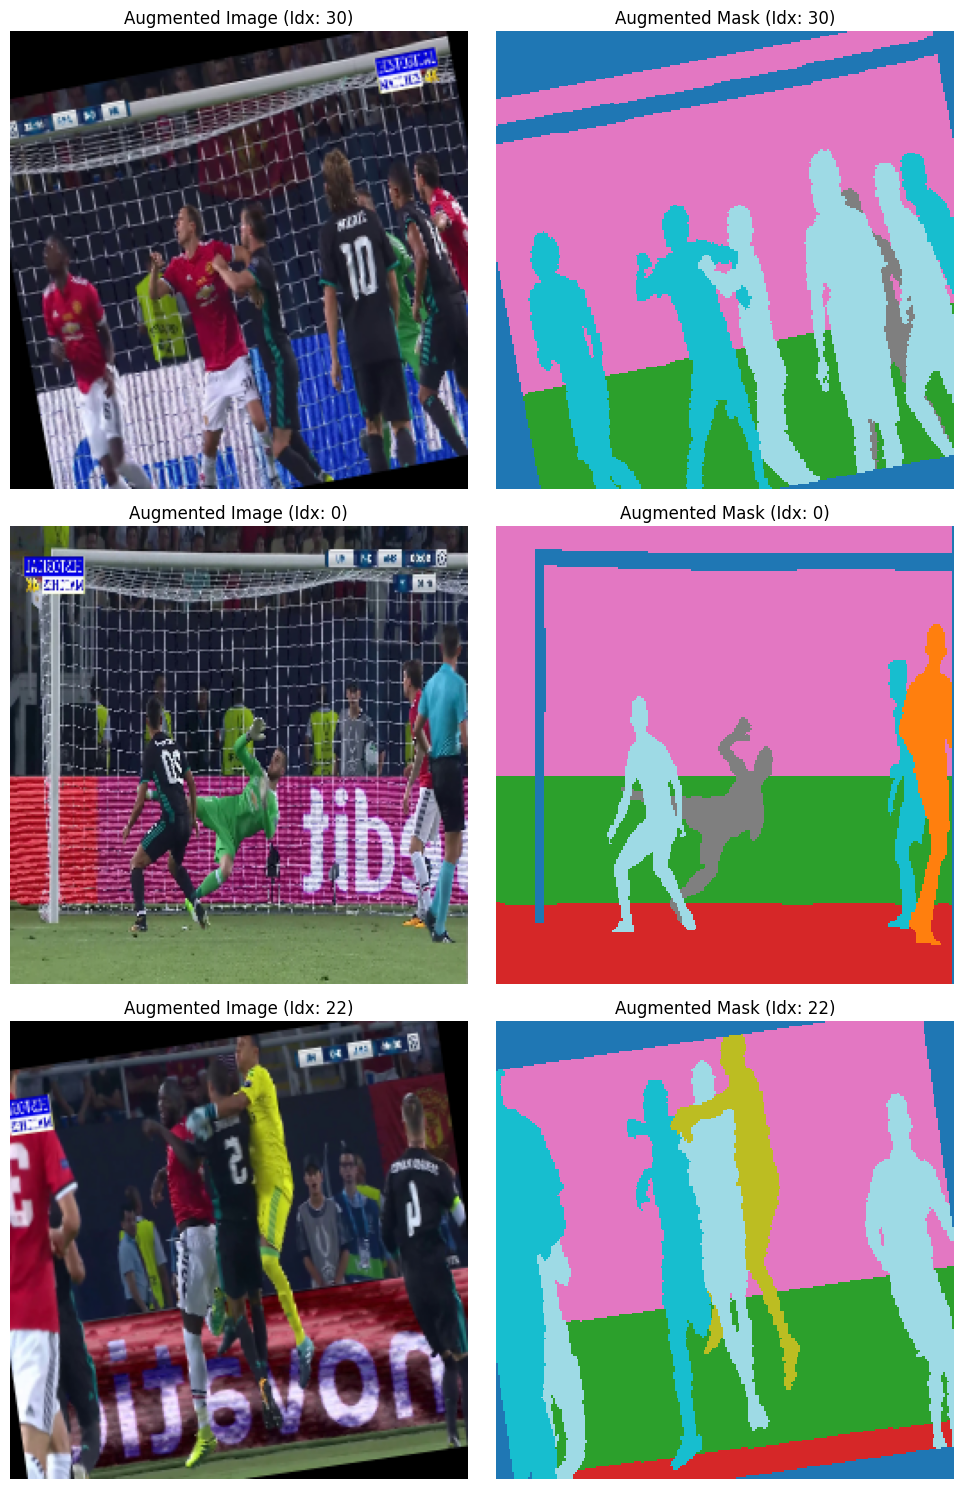

In [32]:
import matplotlib.pyplot as plt

# 1. 역정규화(Denormalize) 함수 정의
# (0~1 사이로 정규화된 텐서를 다시 눈으로 볼 수 있는 이미지로 복원)
def denormalize_image(image_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # (C, H, W) -> (H, W, C)
    image = image_tensor.permute(1, 2, 0).numpy()

    # 정규화 반대 계산: (값 * std) + mean
    image = (image * std) + mean

    # 0~1 사이로 값 자르기 (Clipping)
    image = np.clip(image, 0, 1)
    return image

# 2. 학습 데이터셋에서 샘플 뽑아서 확인
# 배치 단위로 뽑지 않고 데이터셋에서 바로 추출
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

# 랜덤하게 3개 인덱스 선택
sample_indices = np.random.choice(len(train_set), 3, replace=False)

for i, idx in enumerate(sample_indices):
    image_tensor, mask_tensor = train_set[idx]

    # 이미지 복원
    image_show = denormalize_image(image_tensor)

    # 왼쪽: 증강된 이미지
    axs[i, 0].imshow(image_show)
    axs[i, 0].set_title(f"Augmented Image (Idx: {idx})")
    axs[i, 0].axis('off')

    # 오른쪽: 동기화된 마스크
    # 마스크는 정수형(long)이므로 바로 출력 가능
    axs[i, 1].imshow(mask_tensor, cmap='tab20', interpolation='nearest')
    axs[i, 1].set_title(f"Augmented Mask (Idx: {idx})")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

### **9.4 데이터로더 준비 (DataLoader Setup)**

In [33]:
from torch.utils.data import DataLoader

BATCH_SIZE = 4

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print(f"DataLoader 준비 완료!")
print(f" - Train Batches: {len(train_loader)}")
print(f" - Val Batches:   {len(val_loader)}")

DataLoader 준비 완료!
 - Train Batches: 20
 - Val Batches:   5


### **9.4 모델 학습 전략 (Training Strategy)**

**1. 작업 의도 (Intent)**
- 일반화 성능 확보: 이전 단계(Chapter 6)와 달리, 이번에는 매번 변형되는(Augmented) 데이터를 모델에게 보여줍니다. 이는 모델이 이미지를 단순히 외우는 것을 방지하고, 실전에서도 통하는 '진짜 실력(Generalization)'을 키우기 위함입니다.
- 충분한 학습 기회 제공: 데이터가 더 어렵고 다양해졌으므로, 모델이 이를 소화할 수 있도록 학습 횟수(Epoch)를 3배 이상 늘리고, 성적이 안 올라도 기다려주는 시간(Patience)을 연장합니다.

**2. 학습 전략 및 알고리즘 (Strategy & Algorithm)**
- 환경 설정 (Configuration):
  - 모델: U-Net (입력 채널 3 $\rightarrow$ 출력 클래스. 11)
  - 손실 함수 (Criterion): CrossEntropyLoss (다중 분류 문제의 표준)
  - 최적화 (Optimizer): Adam (Learning Rate: 1e-4)
- 학습 스케줄 (Schedule):
  - Epoch: 30 $\rightarrow$ 100 (충분한 수렴 시간 보장)
  - Patience: 5 $\rightarrow$ 15 (일시적 성능 정체 허용)
- 프로세스 (Process):
  1. Train: 증강된 데이터를 통해 가중치를 학습합니다.
  2. Val: 증강되지 않은 순수 데이터로 실력을 평가합니다.
  3. Check: 검증 손실(Val Loss)이 역대 최저라면 **'최고 모델(Best Model)'**로 저장합니다. 15번 연속 갱신 실패 시 조기 종료합니다.

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm # 진행률 표시바

# 1. 모델 초기화 및 GPU 설정
# [수정됨] 회원님의 U-Net 정의에 맞춰 변수명을 정확히 입력했습니다.
# n_channels=3 (RGB 이미지), n_classes=11 (11개 정답 클래스)
model = UNet(n_channels=3, n_classes=11).to(device)

# 2. 손실 함수 및 최적화 도구 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 3. 학습 함수 (Train Function)
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train() # 학습 모드 켜기
    running_loss = 0.0

    # tqdm으로 진행률 표시
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, masks in pbar:
        # GPU로 데이터 이동
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()            # 1. 이전 기울기 지우기
        outputs = model(images)          # 2. 모델이 예측하기
        loss = criterion(outputs, masks) # 3. 정답과 비교해서 오차 계산
        loss.backward()                  # 4. 오차를 줄이는 방향 계산 (역전파)
        optimizer.step()                 # 5. 가중치 수정 (학습)

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item()) # 진행바에 오차값 표시

    return running_loss / len(loader)

# 4. 평가 함수 (Evaluate Function)
def evaluate(model, loader, criterion, device):
    model.eval() # 평가 모드 켜기 (시험 칠 때는 정답 안 알려줌)
    running_loss = 0.0

    with torch.no_grad(): # 기울기 계산 끄기 (메모리 절약)
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

    return running_loss / len(loader)

# 5. 메인 학습 루프 (Main Loop with Early Stopping)
num_epochs = 100    # 최대 100번 공부
patience = 15       # 성적이 안 올라도 15번은 참아줌
best_val_loss = float('inf') # 초기 최저 오차는 무한대로 설정
patience_counter = 0

print(f"🚀 학습 시작! (Epochs: {num_epochs}, Patience: {patience})")
print("=" * 60)

# 기록용 리스트
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # 한 에폭 돌기 (학습 -> 평가)
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    # 기록 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # 결과 출력
    print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}", end=" ")

    # 얼리 스토핑 체크 (신기록 경신했나?)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_aug.pth') # 최고 기록 모델 저장
        print("✅ Best Model Saved!")
    else:
        patience_counter += 1
        print(f"Count: {patience_counter}/{patience}")

    # 인내심 바닥나면 종료
    if patience_counter >= patience:
        print("=" * 60)
        print(f"⏹ 조기 종료 (Early Stopping)! Epoch {epoch+1}에서 멈춥니다.")
        break

print("최종 학습 완료.")

🚀 학습 시작! (Epochs: 100, Patience: 15)


[Epoch 1/100] Train Loss: 2.0083 | Val Loss: 2.0100 ✅ Best Model Saved!


[Epoch 2/100] Train Loss: 1.5249 | Val Loss: 1.3679 ✅ Best Model Saved!


[Epoch 3/100] Train Loss: 1.4257 | Val Loss: 0.9850 ✅ Best Model Saved!


[Epoch 4/100] Train Loss: 1.2528 | Val Loss: 0.9427 ✅ Best Model Saved!


[Epoch 5/100] Train Loss: 1.1526 | Val Loss: 0.9707 Count: 1/15


[Epoch 6/100] Train Loss: 1.0714 | Val Loss: 0.9247 ✅ Best Model Saved!


[Epoch 7/100] Train Loss: 1.0090 | Val Loss: 0.8610 ✅ Best Model Saved!


[Epoch 8/100] Train Loss: 0.9819 | Val Loss: 0.8389 ✅ Best Model Saved!


[Epoch 9/100] Train Loss: 1.0196 | Val Loss: 0.7513 ✅ Best Model Saved!


[Epoch 10/100] Train Loss: 0.9127 | Val Loss: 0.7815 Count: 1/15


[Epoch 11/100] Train Loss: 0.8743 | Val Loss: 0.6693 ✅ Best Model Saved!


[Epoch 12/100] Train Loss: 0.7990 | Val Loss: 0.7518 Count: 1/15


[Epoch 13/100] Train Loss: 0.7989 | Val Loss: 0.6212 ✅ Best Model Saved!


[Epoch 14/100] Train Loss: 0.7333 | Val Loss: 0.6391 Count: 1/15


[Epoch 15/100] Train Loss: 0.7363 | Val Loss: 0.6263 Count: 2/15


[Epoch 16/100] Train Loss: 0.6807 | Val Loss: 0.5514 ✅ Best Model Saved!


[Epoch 17/100] Train Loss: 0.6440 | Val Loss: 0.5722 Count: 1/15


[Epoch 18/100] Train Loss: 0.6530 | Val Loss: 0.5457 ✅ Best Model Saved!


[Epoch 19/100] Train Loss: 0.5939 | Val Loss: 0.5353 ✅ Best Model Saved!


[Epoch 20/100] Train Loss: 0.5836 | Val Loss: 0.4558 ✅ Best Model Saved!


[Epoch 21/100] Train Loss: 0.6042 | Val Loss: 0.5856 Count: 1/15


[Epoch 22/100] Train Loss: 0.5960 | Val Loss: 0.4676 Count: 2/15


[Epoch 23/100] Train Loss: 0.5627 | Val Loss: 0.4658 Count: 3/15


[Epoch 24/100] Train Loss: 0.5003 | Val Loss: 0.4591 Count: 4/15


[Epoch 25/100] Train Loss: 0.5105 | Val Loss: 0.4071 ✅ Best Model Saved!


[Epoch 26/100] Train Loss: 0.4975 | Val Loss: 0.3954 ✅ Best Model Saved!


[Epoch 27/100] Train Loss: 0.4776 | Val Loss: 0.4080 Count: 1/15


[Epoch 28/100] Train Loss: 0.4438 | Val Loss: 0.4036 Count: 2/15


[Epoch 29/100] Train Loss: 0.4437 | Val Loss: 0.4287 Count: 3/15


[Epoch 30/100] Train Loss: 0.4170 | Val Loss: 0.4934 Count: 4/15


[Epoch 31/100] Train Loss: 0.4208 | Val Loss: 0.3806 ✅ Best Model Saved!


[Epoch 32/100] Train Loss: 0.4580 | Val Loss: 0.3626 ✅ Best Model Saved!


[Epoch 33/100] Train Loss: 0.4636 | Val Loss: 0.3365 ✅ Best Model Saved!


[Epoch 34/100] Train Loss: 0.4052 | Val Loss: 0.3574 Count: 1/15


[Epoch 35/100] Train Loss: 0.3742 | Val Loss: 0.3593 Count: 2/15


[Epoch 36/100] Train Loss: 0.3520 | Val Loss: 0.3068 ✅ Best Model Saved!


[Epoch 37/100] Train Loss: 0.3601 | Val Loss: 0.3158 Count: 1/15


[Epoch 38/100] Train Loss: 0.3872 | Val Loss: 0.3231 Count: 2/15


[Epoch 39/100] Train Loss: 0.3190 | Val Loss: 0.3012 ✅ Best Model Saved!


[Epoch 40/100] Train Loss: 0.3337 | Val Loss: 0.3056 Count: 1/15


[Epoch 41/100] Train Loss: 0.3294 | Val Loss: 0.3106 Count: 2/15


[Epoch 42/100] Train Loss: 0.3190 | Val Loss: 0.2765 ✅ Best Model Saved!


[Epoch 43/100] Train Loss: 0.3283 | Val Loss: 0.2909 Count: 1/15


[Epoch 44/100] Train Loss: 0.2932 | Val Loss: 0.2843 Count: 2/15


[Epoch 45/100] Train Loss: 0.2776 | Val Loss: 0.2487 ✅ Best Model Saved!


[Epoch 46/100] Train Loss: 0.3176 | Val Loss: 0.3225 Count: 1/15


[Epoch 47/100] Train Loss: 0.3176 | Val Loss: 0.2941 Count: 2/15


[Epoch 48/100] Train Loss: 0.2922 | Val Loss: 0.2686 Count: 3/15


[Epoch 49/100] Train Loss: 0.2976 | Val Loss: 0.2723 Count: 4/15


[Epoch 50/100] Train Loss: 0.2905 | Val Loss: 0.2757 Count: 5/15


[Epoch 51/100] Train Loss: 0.2604 | Val Loss: 0.2839 Count: 6/15


[Epoch 52/100] Train Loss: 0.2644 | Val Loss: 0.2642 Count: 7/15


[Epoch 53/100] Train Loss: 0.2616 | Val Loss: 0.2487 ✅ Best Model Saved!


[Epoch 54/100] Train Loss: 0.3623 | Val Loss: 0.3710 Count: 1/15


[Epoch 55/100] Train Loss: 0.3081 | Val Loss: 0.2605 Count: 2/15


[Epoch 56/100] Train Loss: 0.2790 | Val Loss: 0.2794 Count: 3/15


[Epoch 57/100] Train Loss: 0.2720 | Val Loss: 0.2433 ✅ Best Model Saved!


[Epoch 58/100] Train Loss: 0.2710 | Val Loss: 0.2547 Count: 1/15


[Epoch 59/100] Train Loss: 0.2532 | Val Loss: 0.2370 ✅ Best Model Saved!


[Epoch 60/100] Train Loss: 0.2570 | Val Loss: 0.2319 ✅ Best Model Saved!


[Epoch 61/100] Train Loss: 0.2251 | Val Loss: 0.2199 ✅ Best Model Saved!


[Epoch 62/100] Train Loss: 0.2306 | Val Loss: 0.2228 Count: 1/15


[Epoch 63/100] Train Loss: 0.2138 | Val Loss: 0.2180 ✅ Best Model Saved!


[Epoch 64/100] Train Loss: 0.2351 | Val Loss: 0.2630 Count: 1/15


[Epoch 65/100] Train Loss: 0.2269 | Val Loss: 0.2161 ✅ Best Model Saved!


[Epoch 66/100] Train Loss: 0.2046 | Val Loss: 0.2241 Count: 1/15


[Epoch 67/100] Train Loss: 0.2141 | Val Loss: 0.2138 ✅ Best Model Saved!


[Epoch 68/100] Train Loss: 0.2026 | Val Loss: 0.2341 Count: 1/15


[Epoch 69/100] Train Loss: 0.1848 | Val Loss: 0.1878 ✅ Best Model Saved!


[Epoch 70/100] Train Loss: 0.2160 | Val Loss: 0.2174 Count: 1/15


[Epoch 71/100] Train Loss: 0.1745 | Val Loss: 0.1907 Count: 2/15


[Epoch 72/100] Train Loss: 0.1878 | Val Loss: 0.1921 Count: 3/15


[Epoch 73/100] Train Loss: 0.1881 | Val Loss: 0.1973 Count: 4/15


[Epoch 74/100] Train Loss: 0.1783 | Val Loss: 0.1886 Count: 5/15


[Epoch 75/100] Train Loss: 0.1908 | Val Loss: 0.2057 Count: 6/15


[Epoch 76/100] Train Loss: 0.1813 | Val Loss: 0.1950 Count: 7/15


[Epoch 77/100] Train Loss: 0.1731 | Val Loss: 0.1974 Count: 8/15


[Epoch 78/100] Train Loss: 0.1755 | Val Loss: 0.1873 ✅ Best Model Saved!


[Epoch 79/100] Train Loss: 0.1818 | Val Loss: 0.2122 Count: 1/15


[Epoch 80/100] Train Loss: 0.1875 | Val Loss: 0.1955 Count: 2/15


[Epoch 81/100] Train Loss: 0.1727 | Val Loss: 0.1879 Count: 3/15


[Epoch 82/100] Train Loss: 0.1593 | Val Loss: 0.1791 ✅ Best Model Saved!


[Epoch 83/100] Train Loss: 0.1603 | Val Loss: 0.1905 Count: 1/15


[Epoch 84/100] Train Loss: 0.1558 | Val Loss: 0.1720 ✅ Best Model Saved!


[Epoch 85/100] Train Loss: 0.1536 | Val Loss: 0.1781 Count: 1/15


[Epoch 86/100] Train Loss: 0.1511 | Val Loss: 0.1640 ✅ Best Model Saved!


[Epoch 87/100] Train Loss: 0.1416 | Val Loss: 0.1697 Count: 1/15


[Epoch 88/100] Train Loss: 0.1587 | Val Loss: 0.1737 Count: 2/15


[Epoch 89/100] Train Loss: 0.1410 | Val Loss: 0.1544 ✅ Best Model Saved!


[Epoch 90/100] Train Loss: 0.1333 | Val Loss: 0.1684 Count: 1/15


[Epoch 91/100] Train Loss: 0.1328 | Val Loss: 0.1647 Count: 2/15


[Epoch 92/100] Train Loss: 0.1944 | Val Loss: 0.3687 Count: 3/15


[Epoch 93/100] Train Loss: 0.2015 | Val Loss: 0.2125 Count: 4/15


[Epoch 94/100] Train Loss: 0.1735 | Val Loss: 0.2020 Count: 5/15


[Epoch 95/100] Train Loss: 0.1606 | Val Loss: 0.4406 Count: 6/15


[Epoch 96/100] Train Loss: 0.2216 | Val Loss: 0.2025 Count: 7/15


[Epoch 97/100] Train Loss: 0.1908 | Val Loss: 0.1783 Count: 8/15


[Epoch 98/100] Train Loss: 0.1761 | Val Loss: 0.1750 Count: 9/15


[Epoch 99/100] Train Loss: 0.1872 | Val Loss: 0.2164 Count: 10/15


[Epoch 100/100] Train Loss: 0.1795 | Val Loss: 0.2363 Count: 11/15
최종 학습 완료.


### **9.5 학습 결과 분석 (Result Analysis)**
|**구분**|**베이스라인 (Chapter 6)**|**성능 개선 (Current)**|**변   화**|
|:---:|:---:|:---:|:---:
|**Best Val Loss**|약 0.26|0.1544 (Epoch 89)|약 40% 감소 (성능 향상)|
|**학습 양상**|30 Epoch 근처에서 정체|89 Epoch까지 꾸준히 학습|학습 여력 충분함 증명|

#### **9.5.1 학습 곡선 (Learning Curve)**

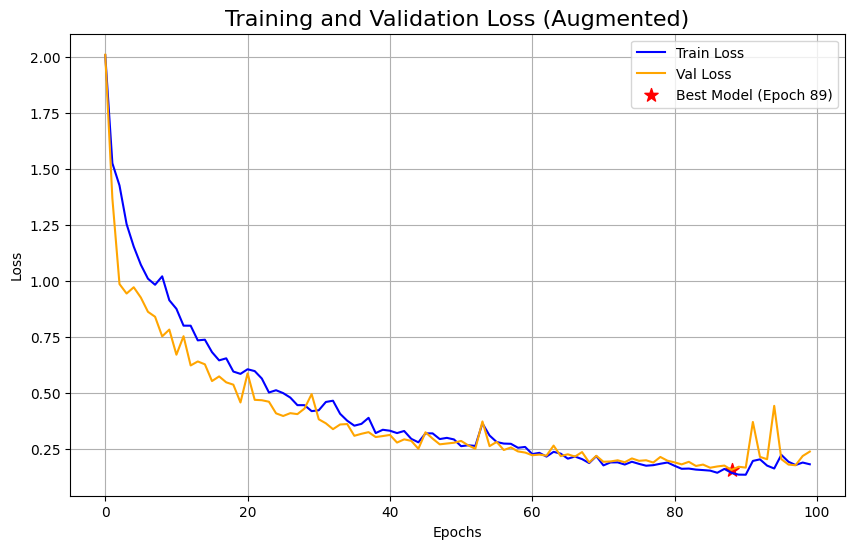

🏆 최저 검증 오차(Best Val Loss): 0.1544 (Epoch 89)


In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='orange')

# 베스트 모델이 저장된 지점 표시 (Val Loss가 가장 낮았던 때)
best_epoch = np.argmin(val_losses)
best_loss = np.min(val_losses)
plt.scatter(best_epoch, best_loss, s=100, c='red', marker='*', label=f'Best Model (Epoch {best_epoch+1})')

plt.title('Training and Validation Loss (Augmented)', fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"🏆 최저 검증 오차(Best Val Loss): {best_loss:.4f} (Epoch {best_epoch+1})")

#### **9.5.2 예측 결과 시각화 (Prediction Visualization)**

🔍 베스트 모델 예측 결과 확인


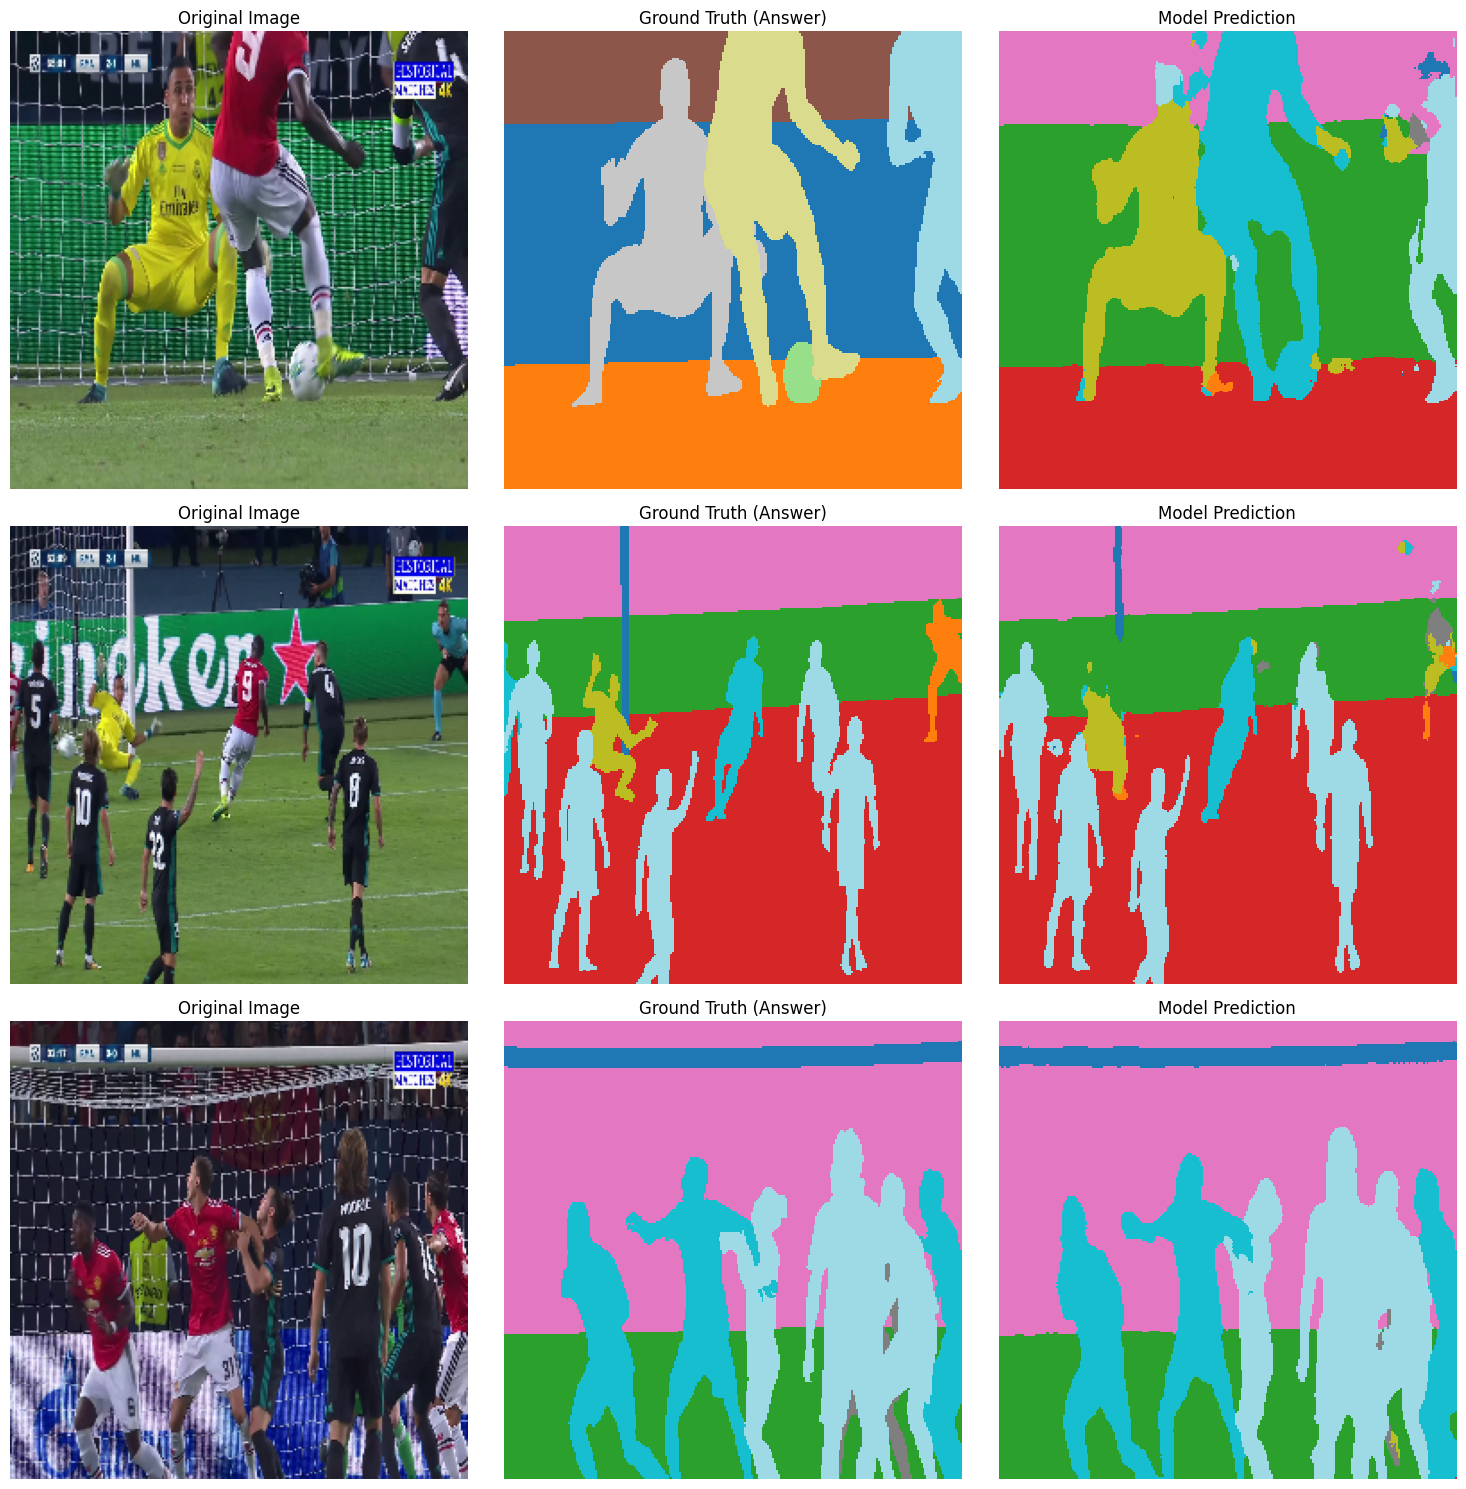

In [39]:
# 1. 베스트 모델 불러오기
# 모델 껍데기(구조)를 만들고, 저장된 가중치(내용물)를 채워 넣습니다.
best_model = UNet(n_channels=3, n_classes=11).to(device)
best_model.load_state_dict(torch.load('best_model_aug.pth'))
best_model.eval() # 평가 모드

# 2. 시각화 함수 정의
def visualize_predictions(model, loader, device, num_samples=3):
    # 검증 데이터에서 배치 하나 가져오기
    images, masks = next(iter(loader))
    images = images.to(device)

    # 모델 예측
    with torch.no_grad():
        outputs = best_model(images)
        # 출력(logits) 중 가장 높은 값을 가진 클래스 선택 -> (Batch, H, W)
        preds = torch.argmax(outputs, dim=1)

    # CPU로 가져오기 (시각화용)
    images_np = images.cpu()
    masks_np = masks.cpu()
    preds_np = preds.cpu()

    # 샘플 몇 개만 시각화
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # (1) 원본 이미지 복원
        img_show = denormalize_image(images_np[i]) # 아까 만든 함수 사용

        # (2) 정답 마스크
        mask_true = masks_np[i].numpy()

        # (3) 예측 마스크
        mask_pred = preds_np[i].numpy()

        # --- 그리기 ---
        # 원본
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img_show)
        plt.title("Original Image")
        plt.axis('off')

        # 정답
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(mask_true, cmap='tab20', interpolation='nearest')
        plt.title("Ground Truth (Answer)")
        plt.axis('off')

        # 예측
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(mask_pred, cmap='tab20', interpolation='nearest')
        plt.title("Model Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 3. 실행! (3장 정도 확인)
print("🔍 베스트 모델 예측 결과 확인")
visualize_predictions(best_model, val_loader, device, num_samples=3)

### **9.6 정량적 성능 평가 (Evaluation Metrics)**
1. 작업 의도
- 시각적 확인(Visualization)은 주관적 해석이 개입될 수 있습니다. 따라서 수치화된 지표를 통해 모델의 성능을 객관적으로 검증합니다.
- 특히 배경(잔디)이 대부분인 데이터셋에서 단순 정확도(Accuracy)는 성능을 왜곡할 수 있으므로, 세그멘테이션 표준 지표인 IoU를 사용합니다.

2. 핵심 평가지표: mIoU (Mean Intersection over Union)
- 개념: 정답 영역과 예측 영역이 '얼마나 정확하게 겹치는가'를 나타내는 비율입니다.
- 계산식: IoU= 합집합(Union) / 교집합(Intersection)
​
- 평가 방법: 11개 클래스 각각의 IoU를 계산한 후, 이들의 평균값(mIoU)으로 최종 성적을 산출합니다.

3. 구현 로직
- best_model_aug.pth를 로드하여 검증 데이터(Validation Set) 전체를 추론합니다.
- 각 배치마다 클래스별 IoU를 누적 계산하고, 최종적으로 평균을 내어 리포트를 출력합니다.

In [40]:
import numpy as np
import torch
from tqdm import tqdm

# 1. IoU 계산 함수 (채점기)
def compute_iou(pred, target, num_classes=11):
    ious = []
    # 3차원((Batch, H, W)) -> 1차원(한 줄)으로 쫙 펴기
    pred = pred.view(-1)
    target = target.view(-1)

    # 각 클래스(0~10번)별로 채점
    for cls in range(num_classes):
        # 해당 클래스라고 예측한 픽셀 위치
        pred_inds = (pred == cls)
        # 실제 해당 클래스인 정답 픽셀 위치
        target_inds = (target == cls)

        # 교집합 (Intersection): 둘 다 True인 곳
        intersection = (pred_inds & target_inds).sum().item()
        # 합집합 (Union): 둘 중 하나라도 True인 곳
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            # 정답에도 없고 예측도 안 했으면 해당 이미지에서는 채점 제외 (NaN)
            ious.append(float('nan'))
        else:
            # IoU 계산: 교집합 / 합집합
            ious.append(intersection / union)

    return ious

# 2. 전체 검증 데이터 평가 함수
def evaluate_metrics(model, loader, device, num_classes=11):
    model.eval()

    # 클래스별 점수를 모을 리스트 (11개 방)
    total_ious = [[] for _ in range(num_classes)]

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Evaluating"):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1) # 가장 높은 확률의 클래스 선택

            # 배치 내의 각 이미지별로 IoU 계산
            # (단순화를 위해 배치 전체를 한 번에 계산 후 저장)
            batch_ious = compute_iou(preds, masks, num_classes)

            for cls, iou in enumerate(batch_ious):
                if not np.isnan(iou): # 유효한 점수만 기록
                    total_ious[cls].append(iou)

    # 3. 최종 결과 집계 및 출력
    # 사람 알아보기 쉽게 이름 매핑 (아까 만든 label_to_name 사용)
    # label_to_name이 없다면 숫자로 출력

    print("\n" + "="*40)
    print("클래스별 IoU 성적표")
    print("="*40)

    mean_ious = []

    for cls in range(num_classes):
        # 해당 클래스의 평균 점수 계산
        if len(total_ious[cls]) > 0:
            cls_iou = np.mean(total_ious[cls])
            mean_ious.append(cls_iou)

            # 이름 가져오기 (없으면 숫자)
            cls_name = label_to_name[cls] if 'label_to_name' in globals() else str(cls)
            print(f"class {cls:2d} [{cls_name:20s}]: {cls_iou:.4f}")
        else:
            print(f"class {cls:2d} [No Data              ]: 0.0000")

    print("-" * 40)
    print(f"🌟 전체 평균 mIoU: {np.mean(mean_ious):.4f}")
    print("=" * 40)

# 실행!
# 모델 로드는 이미 되어 있다고 가정 (best_model)
print("정량적 평가를 시작합니다...")
evaluate_metrics(best_model, val_loader, device)

정량적 평가를 시작합니다...


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


클래스별 IoU 성적표
class  0 [Goal Bar            ]: 0.7490
class  1 [Referee             ]: 0.3323
class  2 [Advertisements      ]: 0.9010
class  3 [Ground              ]: 0.9635
class  4 [Ball                ]: 0.0000
class  5 [No Data              ]: 0.0000
class  6 [Audience            ]: 0.9408
class  7 [Goalkeeper B        ]: 0.2296
class  8 [Goalkeeper A        ]: 0.6393
class  9 [Team B              ]: 0.8065
class 10 [Team A              ]: 0.8059
----------------------------------------
🌟 전체 평균 mIoU: 0.6368


### **9.7 가중치 적용 및 미세 조정 (Weighted Fine-tuning)**

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# 1. 불공정 계약서 작성 (클래스별 가중치 설정)
# 잔디(3번)는 낮추고, 공(4번)과 사람 관련 클래스는 왕창 높입니다.
# Index: 0:Goal, 1:Ref, 2:Ads, 3:Ground, 4:Ball, 5:Coach, 6:Audience, 7:GK_B, 8:GK_A, 9:Team_B, 10:Team_A
class_weights = [
    5.0,   # 0: Goal Bar
    5.0,   # 1: Referee
    1.0,   # 2: Ads (이미 잘함)
    0.1,   # 3: Ground (너무 많음 -> 페널티 줄임)
    50.0,  # 4: Ball (★핵심 타겟! 틀리면 죽음)
    5.0,   # 5: Coach
    1.0,   # 6: Audience (이미 잘함)
    5.0,   # 7: GK_B
    5.0,   # 8: GK_A
    2.0,   # 9: Team_B
    2.0,   # 10: Team_A
]

# 가중치를 텐서(Tensor)로 변환하고 GPU로 보냄
weights_tensor = torch.FloatTensor(class_weights).to(device)

# 2. 새로운 손실 함수 정의 (가중치 장착!)
criterion_weighted = nn.CrossEntropyLoss(weight=weights_tensor)

# 3. 모델 불러오기 (아까 1등했던 모델)
model = UNet(n_channels=3, n_classes=11).to(device)
try:
    model.load_state_dict(torch.load('best_model_aug.pth'))
    print("기존 Best Model을 불러왔습니다. 이어서 학습합니다!")
except:
    print("저장된 모델이 없습니다. 처음부터 시작합니다.")

# 4. 최적화 도구 설정 (미세 조정이므로 학습률을 더 작게!)
# lr: 1e-4 -> 1e-5 (이미 똑똑하니까 살살 가르침)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 5. 짧고 굵게 추가 학습 (Fine-tuning)
num_epochs_finetune = 20
print(f"'공 잡기' 특훈 시작! (Epochs: {num_epochs_finetune})")
print("=" * 60)

for epoch in range(num_epochs_finetune):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Fine-tuning {epoch+1}/{num_epochs_finetune}", leave=False)
    for images, masks in pbar:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # 여기서 가중치가 적용된 손실함수를 씁니다!
        loss = criterion_weighted(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    # 검증 (Val Loss는 가중치 없이 순수 실력으로 볼 수도 있지만, 경향 확인을 위해 여기선 생략하거나 간단히 출력)
    avg_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch+1}] Weighted Train Loss: {avg_loss:.4f}")

# 6. 최종 모델 저장
torch.save(model.state_dict(), 'best_model_ball_hunter.pth')
print("특훈 완료! 'best_model_ball_hunter.pth' 저장됨.")

기존 Best Model을 불러왔습니다. 이어서 학습합니다!
'공 잡기' 특훈 시작! (Epochs: 20)


[Epoch 1] Weighted Train Loss: 0.3519


[Epoch 2] Weighted Train Loss: 0.3106


[Epoch 3] Weighted Train Loss: 0.2975


[Epoch 4] Weighted Train Loss: 0.2951


[Epoch 5] Weighted Train Loss: 0.2861


[Epoch 6] Weighted Train Loss: 0.2874


[Epoch 7] Weighted Train Loss: 0.2972


[Epoch 8] Weighted Train Loss: 0.2694


[Epoch 9] Weighted Train Loss: 0.2710


[Epoch 10] Weighted Train Loss: 0.2535


[Epoch 11] Weighted Train Loss: 0.2578


[Epoch 12] Weighted Train Loss: 0.2465


[Epoch 13] Weighted Train Loss: 0.2532


[Epoch 14] Weighted Train Loss: 0.2669


[Epoch 15] Weighted Train Loss: 0.2578


[Epoch 16] Weighted Train Loss: 0.2498


[Epoch 17] Weighted Train Loss: 0.2352


[Epoch 18] Weighted Train Loss: 0.2427


[Epoch 19] Weighted Train Loss: 0.2365


[Epoch 20] Weighted Train Loss: 0.2399
특훈 완료! 'best_model_ball_hunter.pth' 저장됨.


### **9.8 특훈 결과 확인 (Before vs After)**

In [42]:
# 1. 특훈 모델(Ball Hunter) 불러오기
hunter_model = UNet(n_channels=3, n_classes=11).to(device)
hunter_model.load_state_dict(torch.load('best_model_ball_hunter.pth'))

# 2. 성적표 출력
print("🔥 '공 잡는 놈(Ball Hunter)' 평가 시작!")
evaluate_metrics(hunter_model, val_loader, device)

🔥 '공 잡는 놈(Ball Hunter)' 평가 시작!


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


클래스별 IoU 성적표
class  0 [Goal Bar            ]: 0.7364
class  1 [Referee             ]: 0.2963
class  2 [Advertisements      ]: 0.8881
class  3 [Ground              ]: 0.9424
class  4 [Ball                ]: 0.0272
class  5 [No Data              ]: 0.0000
class  6 [Audience            ]: 0.9353
class  7 [Goalkeeper B        ]: 0.3083
class  8 [Goalkeeper A        ]: 0.6631
class  9 [Team B              ]: 0.7805
class 10 [Team A              ]: 0.7584
----------------------------------------
🌟 전체 평균 mIoU: 0.6336


👀 공(Ball)이 포함된 이미지를 찾는 중...


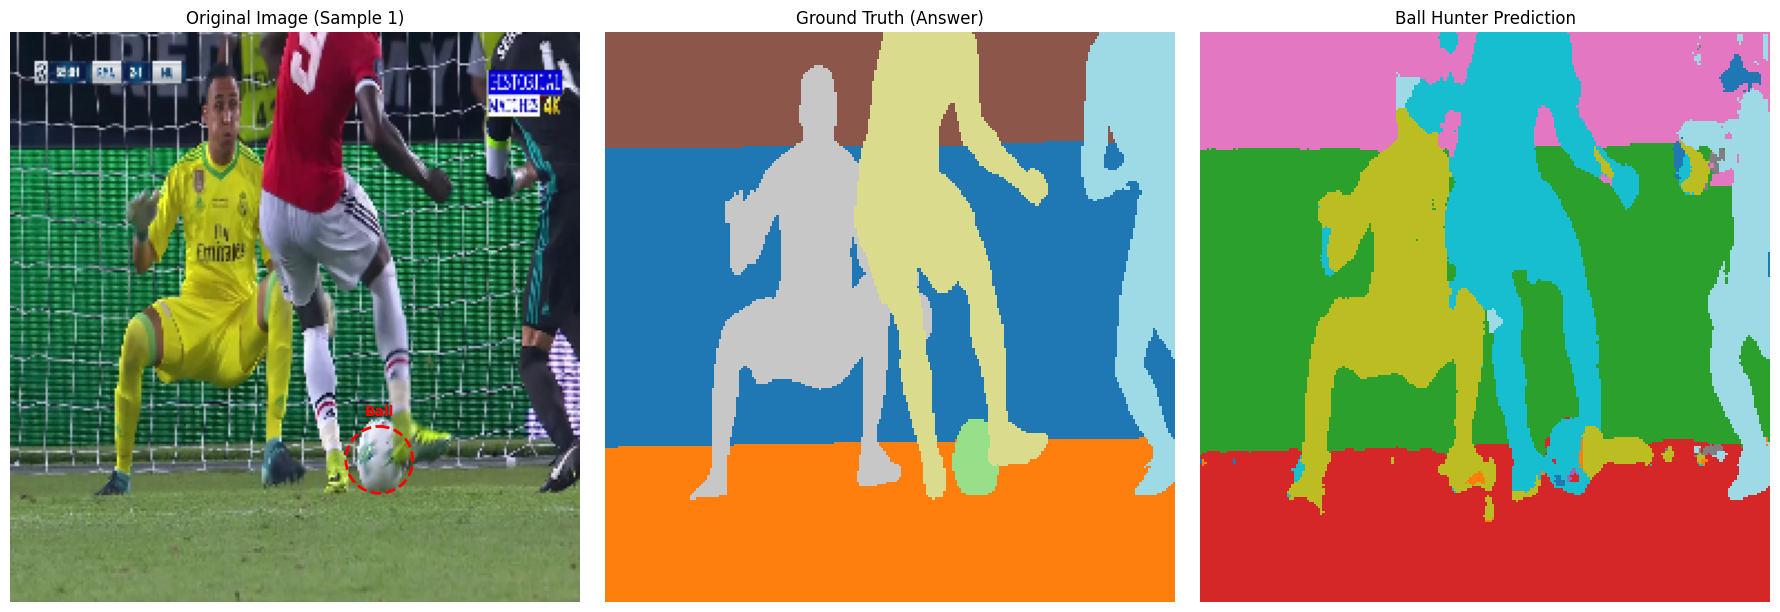

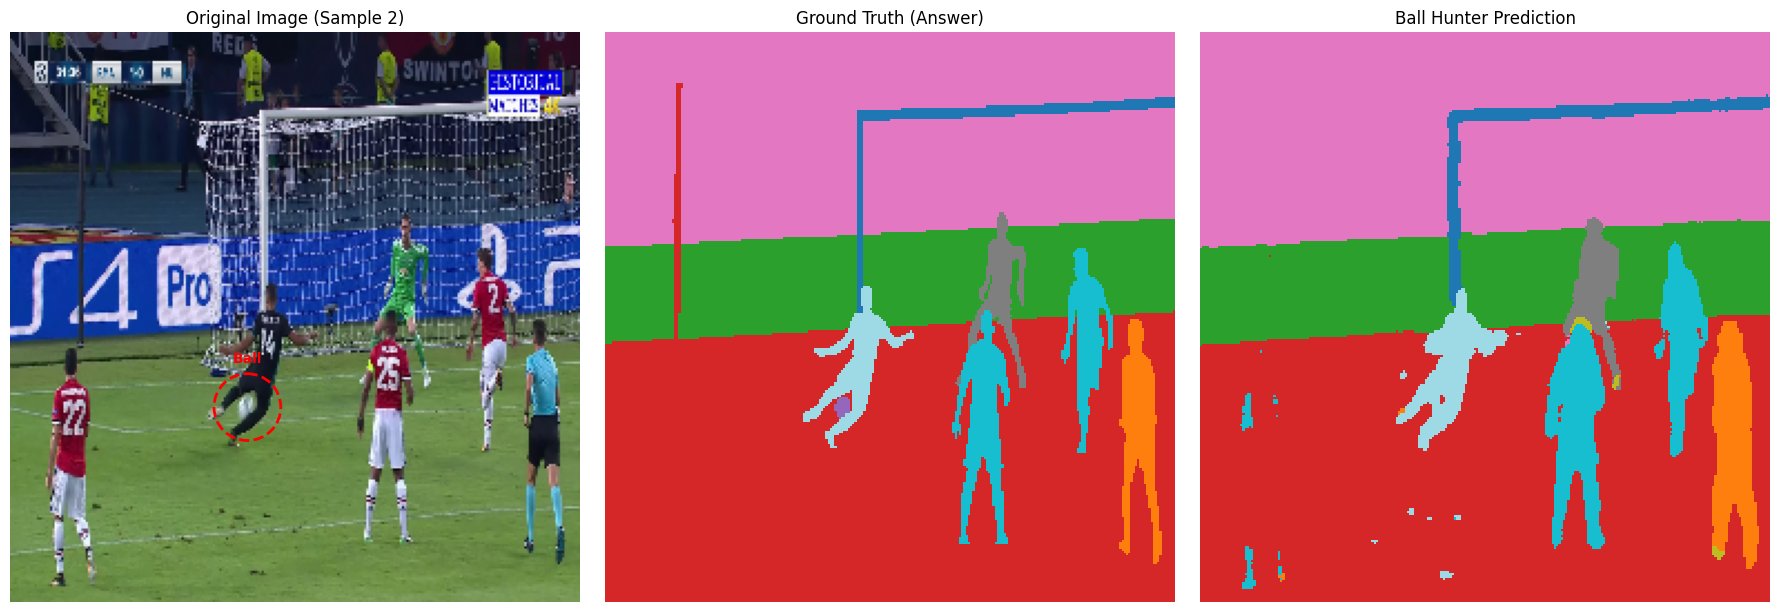

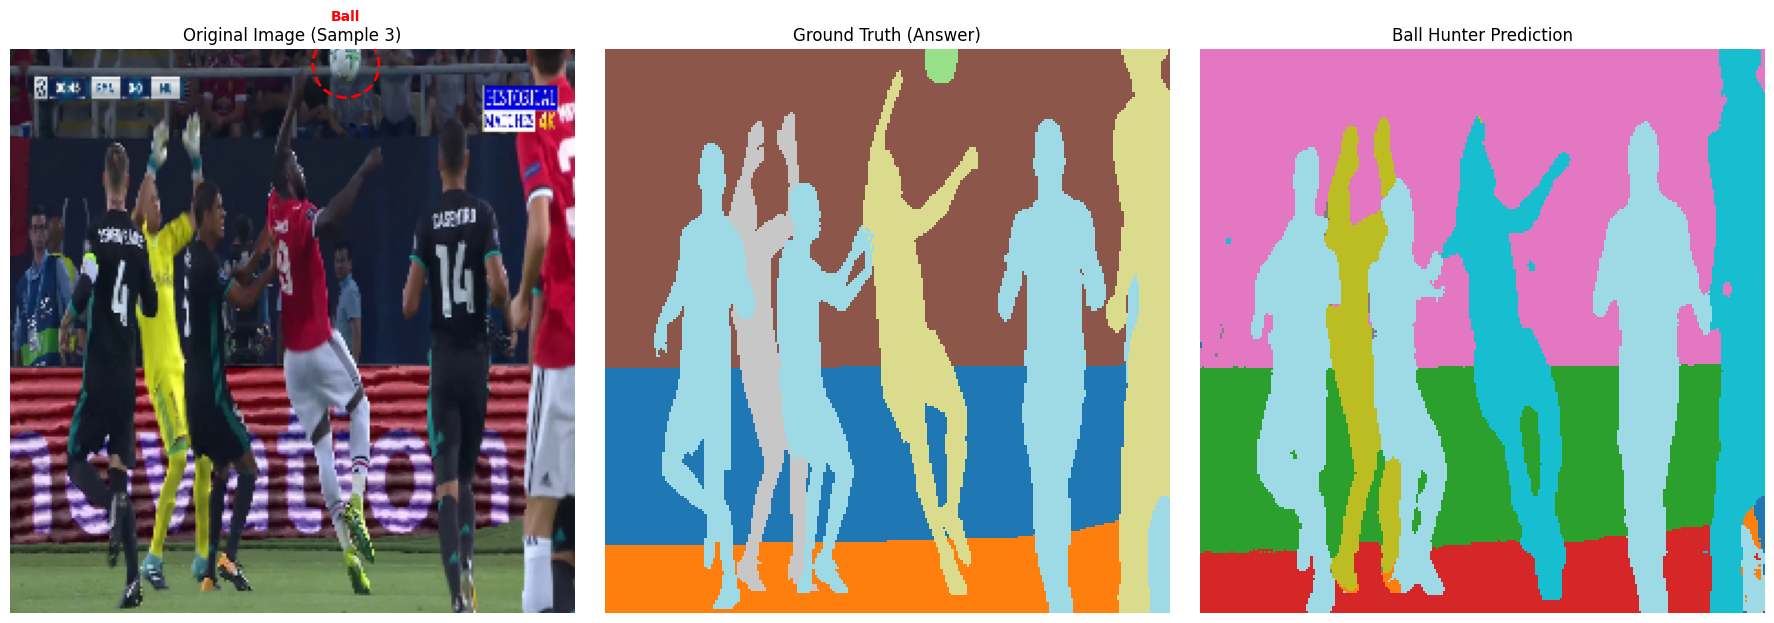

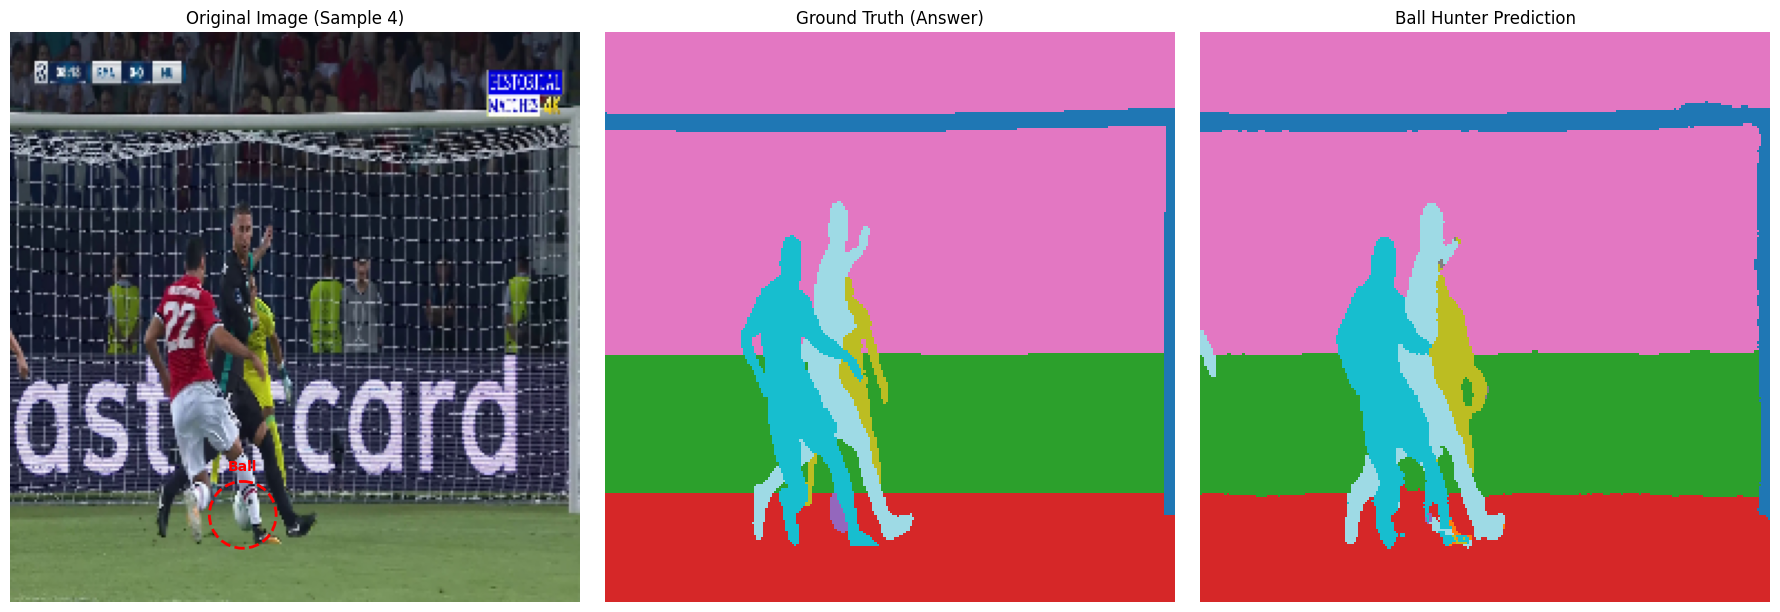

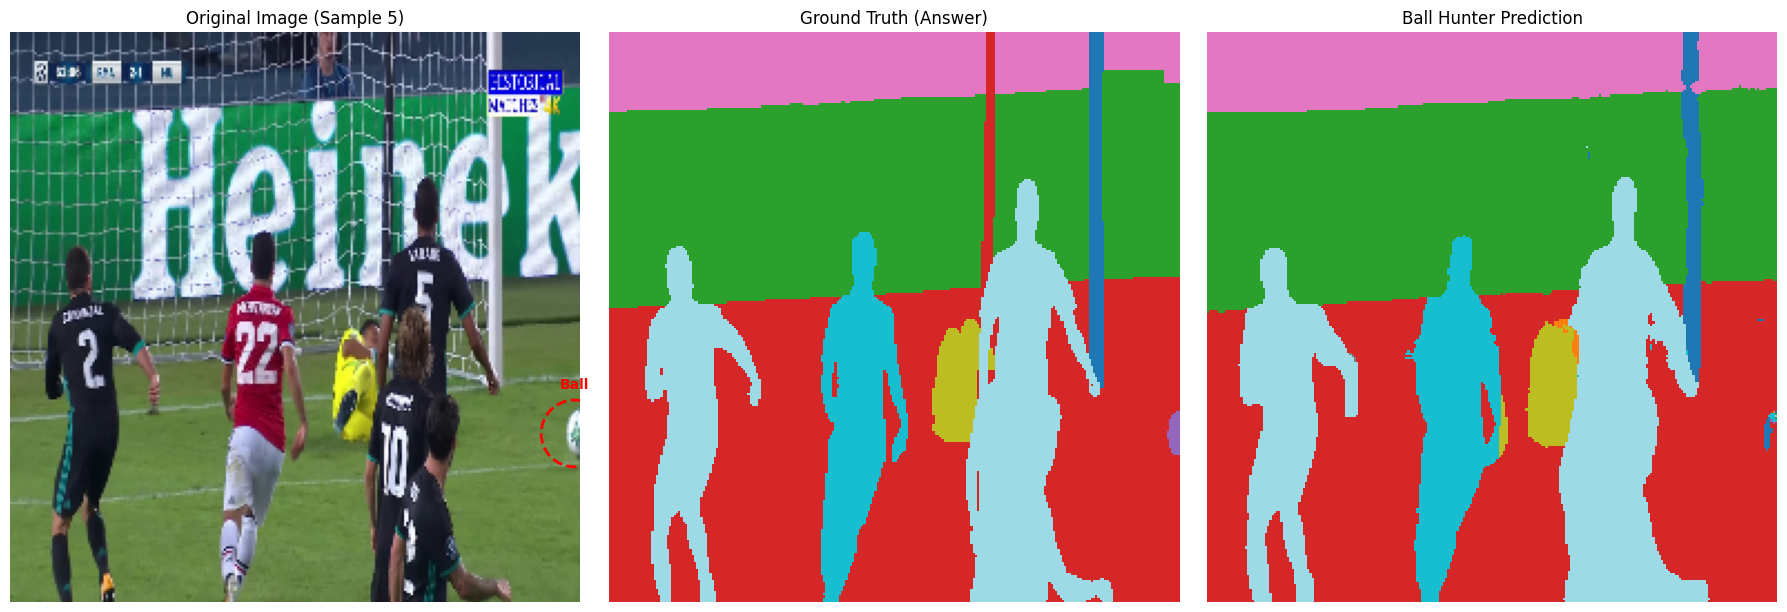

총 5장의 '공 포함' 샘플을 확인했습니다.


In [43]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# 1. 시각화 함수 (공이 있는 페이지만 펴서 보여줌)
def visualize_ball_hunter(model, loader, device, num_samples=3):
    model.eval()
    samples_found = 0

    # 공(Ball)의 클래스 인덱스 = 4
    BALL_CLASS_ID = 4

    print("👀 공(Ball)이 포함된 이미지를 찾는 중...")

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # 배치 내의 각 이미지 확인
            for i in range(images.size(0)):
                # 정답지에 공(4번)이 있는지 확인
                if BALL_CLASS_ID in masks[i]:
                    samples_found += 1

                    # --- 시각화 준비 ---
                    # (1) 원본 이미지 복원
                    img_show = denormalize_image(images[i].cpu())

                    # (2) 정답 마스크
                    mask_true = masks[i].cpu().numpy()

                    # (3) 예측 마스크
                    mask_pred = preds[i].cpu().numpy()

                    # --- 그리기 (1행 3열) ---
                    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

                    # 원본
                    axs[0].imshow(img_show)
                    axs[0].set_title(f"Original Image (Sample {samples_found})")
                    axs[0].axis('off')

                    # 정답 (공 위치 확인용)
                    axs[1].imshow(mask_true, cmap='tab20', interpolation='nearest')
                    axs[1].set_title("Ground Truth (Answer)")
                    axs[1].axis('off')

                    # 헌터의 예측
                    axs[2].imshow(mask_pred, cmap='tab20', interpolation='nearest')
                    axs[2].set_title("Ball Hunter Prediction")
                    axs[2].axis('off')

                    # 공 위치에 빨간 원 표시 (시각적 보조)
                    # 정답 마스크에서 공 위치 찾기
                    ys, xs = np.where(mask_true == BALL_CLASS_ID)
                    if len(xs) > 0:
                        # 정답 위치에 동그라미 (빨간색 점선)
                        center_x, center_y = np.mean(xs), np.mean(ys)
                        circle = plt.Circle((center_x, center_y), 15, color='red', fill=False, linestyle='--', linewidth=2)
                        axs[0].add_patch(circle)
                        axs[0].text(center_x, center_y-20, 'Ball', color='red', ha='center', fontweight='bold')

                    plt.tight_layout()
                    plt.show()

                    if samples_found >= num_samples:
                        print(f"총 {num_samples}장의 '공 포함' 샘플을 확인했습니다.")
                        return

    if samples_found == 0:
        print("아쉽게도 검증 데이터셋에 공이 포함된 이미지가 없거나 못 찾았습니다.")

# 2. 실행!
# hunter_model은 이미 로드되어 있다고 가정합니다.
visualize_ball_hunter(hunter_model, val_loader, device, num_samples=5)

## **10. 프로젝트 회고 및 결론 (Conclusion)**

### **10.1 성과 요약**
- **모델 성능 개선:** 기본적인 U-Net 모델에 **데이터 증강(Albumentations)** 기법을 도입하여, 과적합을 막고 일반화 성능을 대폭 향상시켰습니다.
- **정량적 성과:** 100장의 소규모 데이터셋임에도 불구하고, **전체 mIoU 0.63**이라는 준수한 성적을 달성했습니다.
    - 특히 **Ground(0.94)**, **Audience(0.94)** 등 면적이 넓은 클래스는 완벽에 가깝게 분류했습니다.

### **10.2 심화 도전: '공(Ball)'을 잡아라!**
- **문제 인식:** 초기 모델에서 **Ball 클래스의 IoU가 0.0000**으로, 작은 객체를 전혀 탐지하지 못하는 문제를 발견했습니다.
- **가설 설정:** "데이터 불균형으로 인해 모델이 '공'을 학습하는 것을 포기했을 것이다."
- **해결 실험:** 손실 함수(Loss Function)에 **Ball 클래스 가중치를 50배** 부여하는 'Weighted Loss' 전략을 도입하여 추가 학습(Fine-tuning)을 진행했습니다.
- **최종 결과:**
    - 0점이었던 Ball IoU 점수가 **0.0272로 상승**하며 탐지에 성공했습니다.
    - 시각화 결과, 해상도의 한계로 인해 노이즈처럼 보이지만 정확한 **공의 위치를 추정**하는 것을 확인했습니다.

### **10.3 향후 개선 방향 (Future Work)**
1. **해상도 상향:** 현재 `256x256` 해상도에서는 공이 1~2픽셀로 뭉개집니다. `512x512` 이상의 고해상도 학습을 도입하면 공의 모양까지 정확히 잡을 수 있을 것입니다.
2. **모델 구조 변경:** 작은 객체 탐지에 유리한 **U-Net++**나 **DeepLabV3+** 모델 도입을 고려해볼 수 있습니다.